# Assignment 4

## BasketTube - the AI Game Analyzer
Basketball games are complex, dynamic environments where players must make quick decisions based on their understanding of the game state. In this assignment, you will explore how to extract player actions from a basketball game such as the one shown below

https://youtu.be/LPDnemFoqVk

You can use the following Colab notebook to complete this assignment: [Basketball State Extraction
](https://colab.research.google.com/drive/16XYmF7T6X54MVq7mPpZOEoSKtedohl70?usp=sharing)


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# Extract audio from the video using ffmpeg
import os

video_path = '/content/drive/MyDrive/CS6613 Artifical Intelligence/basketball_game.mp4'
trimmed_video_path = 'trimmed_game.mp4'
audio_path = 'game_audio.wav'

# 1. Trim the video to the first 10 minutes (600 seconds)
!ffmpeg -y -i "{video_path}" -t 600 -c:v copy -c:a copy "{trimmed_video_path}"

# 2. Extract the audio from the trimmed video
!ffmpeg -y -i "{trimmed_video_path}" -vn -acodec pcm_s16le -ar 16000 -ac 1 "{audio_path}"

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

### Task 1 - Analyzing Player Performance from Commentary

You should be able to respond to user queries in a chat interface that mimic Google’s responses to queries such as:

> Q: “Analyze the player that scored the most in this game”

> A: While the video does not provide a final leading scorer for the entire game, Stephen Curry is noted as having the most points among the individual player scores mentioned in the first half, reaching 12 points by (37:12).

> Here’s an analysis of his performance in the first half:
> Early Struggles and Defensive Coverage: The Lakers made it difficult for Curry early in the game (16:22). He took only three shots initially (15:17) as the Lakers forced him to get rid of the ball, often with two defenders when he came off a pick and roll (15:10-15:16).

> First Field Goal: Curry scored his first field goal later in the first half (11:06).

> Offensive Impact: By the end of the first half, he came “alive from three-point range” (42:22-42:25), hitting back-to-back three-pointers (37:09-37:12, 42:01-42:08), helping the Warriors extend their lead to 13 points by halftime (42:10).

> Overall Role: He was described as the oldest scoring champion in the NBA in 23 years, showcasing his elite scoring ability (19:09-19:12). LeBron James even called him the MVP, stating he had the best season all year (19:23-19:29).

> Underrated Aspects: Commentators highlighted his rebounding and finishing around the rim as underrated aspects of his game (18:54-19:06).

Note that this is based on the commentary provided in the video and may not reflect the reality (see task 2).





In [2]:
!pip install openai-whisper -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.2/803.2 kB 49.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [11]:
import whisper
from datetime import timedelta
import os

audio_path = "game_audio.wav"

def format_ts(seconds: float) -> str:
    """Convert seconds to H:MM:SS.mmm format."""
    td = timedelta(seconds=seconds)
    total_seconds = int(td.total_seconds())
    ms = int((seconds - total_seconds) * 1000)
    h = total_seconds // 3600
    m = (total_seconds % 3600) // 60
    s = total_seconds % 60
    return f"{h:01d}:{m:02d}:{s:02d}.{ms:03d}"

if os.path.exists(audio_path):
    print("Loading Whisper model...")
    model = whisper.load_model("base")

    print("Transcribing (this may take a moment)...")
    result = model.transcribe(audio_path)

    # Print a preview
    print("Transcription preview:")
    print(result["text"][:500] + "...")

    # Save to file
    with open("transcription_with_timestamps.txt", "w", encoding="utf-8") as f:
        for seg in result["segments"]:
            start = format_ts(seg["start"])
            end = format_ts(seg["end"])
            text = seg["text"].strip()
            f.write(f"[{start} --> {end}] {text}\n")
    print("\nTranscription saved to transcription_with_timestamps.txt")
else:
    print(f"File {audio_path} not found. Please ensure the audio extraction step was successful.")

Loading Whisper model...


100%|████████████████████████████████████████| 139M/139M [00:00<00:00, 286MiB/s]


Transcribing (this may take a moment)...
Transcription preview:
 I was not breaking news. They're a different basketball team with a healthy whole LeBron James 15 games over 500 when he's healthy three games under 500 Creates offense for himself and his teammates. They need him They all Jeff Steph Curry what he's done over the past month and a half has been absolutely brilliant He says valuable as any player in this league they play great defense and they have the ultimate home run hitter Up beneath the team. It hasn't been easy this season But both finished...

Transcription saved to transcription_with_timestamps.txt


In [4]:
# Install necessary libraries for Llama-3 and quantization
!pip install transformers accelerate bitsandbytes -U -q

import torch
from transformers import pipeline, BitsAndBytesConfig
from huggingface_hub import login
from google.colab import userdata
from transformers import AutoTokenizer, AutoModelForCausalLM

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.9/380.9 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 45.8 MB/s eta 0:00:00


In [12]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    print(f"CUDA is available. Device: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is NOT available. Using CPU.")

CUDA is available. Device: NVIDIA A100-SXM4-80GB


In [6]:
# 1. Authenticate with Hugging Face
# Ensure you have accepted the license for meta-llama/Meta-Llama-3-8B-Instruct
try:
    hf_token = userdata.get('HF_TOKEN')
    login(token=hf_token)
except Exception:
    print("HF_TOKEN not found in secrets. Please login manually below:")
    login()

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.1-8B-Instruct")
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.1-8B-Instruct")
messages = [
    {"role": "user", "content": "Who are you?"},
]
inputs = tokenizer.apply_chat_template(
	messages,
	add_generation_prompt=True,
	tokenize=True,
	return_dict=True,
	return_tensors="pt",
).to(model.device)

outputs = model.generate(**inputs, max_new_tokens=40)
print(tokenizer.decode(outputs[0][inputs["input_ids"].shape[-1]:]))

print("Model loaded successfully!")

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


I'm an artificial intelligence model known as Llama. Llama stands for "Large Language Model Meta AI."<|eot_id|>
Model loaded successfully!


In [7]:
def answer_query(query, context, tokenizer=tokenizer, model=model, max_new_tokens=256):
    """
    Generates an answer to a query based on commentary context,
    mimicking the analytical style provided in the example,
    but using a chat-style Llama 3.1 model.
    """

    example_qa = """
Q: "Analyze the player that scored the most in this game"

A: While the video does not provide a final leading scorer for the entire game, Stephen Curry is noted as having the most points among the individual player scores mentioned in the first half, reaching 12 points by (37:12).

Here’s an analysis of his performance in the first half: Early Struggles and Defensive Coverage: The Lakers made it difficult for Curry early in the game (16:22). He took only three shots initially (15:17) as the Lakers forced him to get rid of the ball, often with two defenders when he came off a pick and roll (15:10-15:16).

First Field Goal: Curry scored his first field goal later in the first half (11:06).

Offensive Impact: By the end of the first half, he came “alive from three-point range” (42:22-42:25), hitting back-to-back three-pointers (37:09-37:12, 42:01-42:08), helping the Warriors extend their lead to 13 points by halftime (42:10).

Overall Role: He was described as the oldest scoring champion in the NBA in 23 years, showcasing his elite scoring ability (19:09-19:12). LeBron James even called him the MVP, stating he had the best season all year (19:23-19:29).

Underrated Aspects: Commentators highlighted his rebounding and finishing around the rim as underrated aspects of his game (18:54-19:06).
"""

    # Build the user message in the same structure as your old prompt
    user_content = (
        "### Example Style\n"
        f"{example_qa}\n###\n\n"
        "Commentary Context:\n"
        f"{context[:1500]}\n\n"
        f'Q: "{query}"\n\n'
        "A:"
    )

    messages = [
        {
            "role": "system",
            "content": (
                "You are an analytical basketball commentator. "
                "Answer concisely but with clear structure, following the style of the example."
            ),
        },
        {"role": "user", "content": user_content},
    ]

    # Tokenize using the chat template
    inputs = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        tokenize=True,
        return_dict=True,
        return_tensors="pt",
    ).to(model.device)

    # Generate completion
    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        pad_token_id=tokenizer.eos_token_id,
        # Optional: uncomment if you want sampling instead of greedy
        # do_sample=True,
        # temperature=0.7,
        # top_p=0.9,
    )

    # Only decode the newly generated tokens (not the prompt)
    generated_tokens = outputs[0][inputs["input_ids"].shape[-1]:]
    answer_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)

    return answer_text.strip()


In [13]:
context = open("/content/transcription_with_timestamps.txt").read()
ans = answer_query("Analyze the player that scored the most in this game", context)
print(ans)

While the commentary does not explicitly mention the leading scorer, Stephen Curry is noted as having a brilliant performance in the past month and a half, being described as "absolutely brilliant" and "valuable as any player in this league." 

Here's an analysis of his performance in this game: Early Impact: Curry creates offense for himself and his teammates, showcasing his ability to drive and set up teammates for scoring opportunities (0:00:10.439 - 0:00:19.640).

Key Plays: Curry is involved in key plays, such as Andrew Wiggins getting inside and scoring (0:01:06.719 - 0:01:09.320).

Overall Role: As a key player for the Warriors, Curry's performance is crucial to their success, especially considering the team's recent strong finish to the regular season (0:00:30.759 - 0:00:36.039).


In [14]:
context = open("/content/transcription_with_timestamps.txt").read()
ans = answer_query("Who are the players on the roster for each team?", context)
print(ans)

Based on the provided commentary context, it appears to be a discussion about the upcoming playoff series between the Lakers and the Warriors. While the commentary does not explicitly mention the players on each roster, we can infer some information.

**Los Angeles Lakers:**

- LeBron James: The Lakers' star player, who is expected to play despite a right ankle injury.
- Anthony Davis: The Lakers' dominant big man, who took a tough shot well defended by Dremont Green.

**Golden State Warriors:**

- Stephen Curry: The Warriors' point guard, who has been playing exceptionally well over the past month and a half.
- Andrew Wiggins: The Warriors' forward, who got inside and scored a bucket.

Other players who are likely part of the rosters but not mentioned in the commentary include:

- Dremont Green: A Warriors player who defended Anthony Davis well.
- Jeff Green: A Warriors player who was mentioned alongside Stephen Curry.
- Draymond Green: A Warriors player who was mentioned as defending

### Task 2 - Verifying Player Actions from Video

You should be able to verify the actions of a player by analyzing the video footage itself. For example, if a user asks about a specific player’s performance, you should be able to provide evidence from the video to support your analysis.

In [15]:
import os
from google.colab import userdata

os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")
os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")

# Check GPU
!nvidia-smi

from pathlib import Path
HOME = Path.cwd()
print("HOME:", HOME)

Sun Nov 23 20:45:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   34C    P0             56W /  400W |     997MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [16]:
# Install SAM2 Real-Time
!git clone https://github.com/Gy920/segment-anything-2-real-time.git
%cd {HOME}/segment-anything-2-real-time
!pip install -e . -q
!python setup.py build_ext --inplace

# Download checkpoints
!(cd checkpoints && bash download_ckpts.sh)

%cd {HOME}

Cloning into 'segment-anything-2-real-time'...
remote: Enumerating objects: 406, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 406 (delta 65), reused 56 (delta 56), pack-reused 314 (from 2)
Receiving objects: 100% (406/406), 79.43 MiB | 14.15 MiB/s, done.
Resolving deltas: 100% (91/91), done.
/content/segment-anything-2-real-time
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 16.0 MB/s eta 0:00:00
  Building editable for SAM-2 (pyproject.toml) ... done
running build_ext
W1123 20:49:57.178000 7039 torch/utils/cpp_extension.py:630] Attempted to use ninja as the BuildExtension backend b

In [17]:
!pip install -q inference-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.7/105.7 kB 11.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.4/99.4 kB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 65.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 121.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.1/190.1 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 8.

In [18]:
!pip install supervision==0.27.0rc4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 kB 17.3 MB/s eta 0:00:00
  Attempting uninstall: supervision
    Found existing installation: supervision 0.27.0
    Uninstalling supervision-0.27.0:
      Successfully uninstalled supervision-0.27.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inference-gpu 0.62.0 requires supervision>=0.27, but you have supervision 0.27.0rc4 which is incompatible.


In [19]:
!pip install -q transformers num2words

In [20]:
# !pip install -q flash-attn --no-build-isolation

In [21]:
!pip install -q git+https://github.com/roboflow/sports.git@feat/basketball

  Preparing metadata (setup.py) ... done


In [22]:
!pip check

ipython 7.34.0 requires jedi, which is not installed.
inference-gpu 0.62.0 has requirement supervision>=0.27, but you have supervision 0.27.0rc4.
google-colab 1.0.0 has requirement pandas==2.2.2, but you have pandas 2.3.3.
typeguard 4.4.4 has requirement typing_extensions>=4.14.0, but you have typing-extensions 4.12.2.
pydrive2 1.21.3 has requirement cryptography<44, but you have cryptography 46.0.3.
pydrive2 1.21.3 has requirement pyOpenSSL<=24.2.1,>=19.1.0, but you have pyopenssl 25.3.0.
bigframes 2.29.1 has requirement rich<14,>=12.4.4, but you have rich 14.2.0.


In [23]:
# Install Dependencies
# !pip install -q inference-gpu
# !pip install -q git+https://github.com/roboflow/sports.git@feat/basketball
# !pip install -q transformers num2words
# !pip install -q flash-attn --no-build-isolation

os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"] = "[CUDAExecutionProvider]"

In [24]:
!pip install scenedetect

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.9/130.9 kB 12.7 MB/s eta 0:00:00


In [25]:
# Import dependencies
from IPython.display import Video
from typing import Dict, List, Optional, Union, Iterable, Tuple
from operator import itemgetter

import cv2
import numpy as np
import torch
from tqdm import tqdm

import supervision as sv
from inference import get_model
from sports import (
    clean_paths,
    ConsecutiveValueTracker,
    TeamClassifier,
    MeasurementUnit,
    ViewTransformer
)
from sports.basketball import (
    CourtConfiguration,
    League,
    draw_court,
    draw_points_on_court,
    draw_paths_on_court
)

from scenedetect import detect, ContentDetector

ModelDependencyMissing: Your `inference` configuration does not support SAM model. Use pip install 'inference[sam]' to install missing requirements.To suppress this warning, set CORE_MODEL_SAM_ENABLED to False.
ModelDependencyMissing: Your `inference` configuration does not support SAM2 model. Use pip install 'inference[sam]' to install missing requirements.To suppress this warning, set CORE_MODEL_SAM2_ENABLED to False.
ModelDependencyMissing: Your `inference` configuration does not support SAM3 model. Install SAM3 dependencies and set CORE_MODEL_SAM3_ENABLED to True.
ModelDependencyMissing: Your `inference` configuration does not support Gaze Detection model. Use pip install 'inference[gaze]' to install missing requirements.To suppress this warning, set CORE_MODEL_GAZE_ENABLED to False.
ModelDependencyMissing: Your `inference` configuration does not support GroundingDINO model. Use pip install 'inference[grounding-dino]' to install missing requirements.To suppress this warning, set CO

In [26]:
# Load Detection Models
PLAYER_DETECTION_MODEL_ID = "basketball-player-detection-3-ycjdo/4"
PLAYER_DETECTION_MODEL_CONFIDENCE = 0.4
PLAYER_DETECTION_MODEL_IOU_THRESHOLD = 0.9
PLAYER_DETECTION_MODEL = get_model(model_id=PLAYER_DETECTION_MODEL_ID)
print("Player Detection Model Loaded")

NUMBER_RECOGNITION_MODEL_ID = "basketball-jersey-numbers-ocr/3"
NUMBER_RECOGNITION_MODEL = get_model(model_id=NUMBER_RECOGNITION_MODEL_ID)
NUMBER_RECOGNITION_MODEL_PROMPT = "Read the number."
print("OCR Model Loaded")

KEYPOINT_DETECTION_MODEL_ID = "basketball-court-detection-2/14"
KEYPOINT_DETECTION_MODEL_CONFIDENCE = 0.3
KEYPOINT_DETECTION_MODEL_ANCHOR_CONFIDENCE = 0.5
KEYPOINT_DETECTION_MODEL = get_model(model_id=KEYPOINT_DETECTION_MODEL_ID)
print("Court Detection Model Loaded")

# Class IDs
NUMBER_CLASS_ID = 2
PLAYER_CLASS_IDS = [3, 4, 5, 6, 7]  # player, player-in-possession, player-jump-shot, player-layup-dunk, player-shot-block

# Color palette
COLOR = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff66ff", "#3399ff", "#ff66b2", "#ff8080",
    "#b266ff", "#9999ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])

Player Detection Model Loaded
OCR Model Loaded
Court Detection Model Loaded


In [27]:
# Load SAM2 Tracker
%cd {HOME}/segment-anything-2-real-time

from sam2.build_sam import build_sam2_camera_predictor

SAM2_CHECKPOINT = "checkpoints/sam2.1_hiera_large.pt"
SAM2_CONFIG = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_camera_predictor(SAM2_CONFIG, SAM2_CHECKPOINT)

%cd {HOME}

/content/segment-anything-2-real-time
/content


In [28]:
# SAM2 Tracker Class

class SAM2Tracker:
    """Wrapper for SAM2 camera predictor for tracking players."""

    def __init__(self, predictor) -> None:
        self.predictor = predictor
        self._prompted = False

    def prompt_first_frame(self, frame: np.ndarray, detections: sv.Detections) -> None:
        if len(detections) == 0:
            raise ValueError("detections must contain at least one box")

        if detections.tracker_id is None:
            detections.tracker_id = list(range(1, len(detections) + 1))

        with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
            self.predictor.load_first_frame(frame)
            for xyxy, obj_id in zip(detections.xyxy, detections.tracker_id):
                bbox = np.asarray([xyxy], dtype=np.float32)
                self.predictor.add_new_prompt(
                    frame_idx=0,
                    obj_id=int(obj_id),
                    bbox=bbox,
                )
        self._prompted = True

    def propagate(self, frame: np.ndarray) -> sv.Detections:
        if not self._prompted:
            raise RuntimeError("Call prompt_first_frame before propagate")

        with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
            tracker_ids, mask_logits = self.predictor.track(frame)

        tracker_ids = np.asarray(tracker_ids, dtype=np.int32)
        masks = (mask_logits > 0.0).cpu().numpy()
        masks = np.squeeze(masks).astype(bool)

        if masks.ndim == 2:
            masks = masks[None, ...]

        # Filter small mask fragments
        masks = np.array([
            sv.filter_segments_by_distance(mask, relative_distance=0.03, mode="edge")
            for mask in masks
        ])

        xyxy = sv.mask_to_xyxy(masks=masks)
        detections = sv.Detections(xyxy=xyxy, mask=masks, tracker_id=tracker_ids)
        return detections

    def reset(self) -> None:
        self._prompted = False

In [29]:
# Video and Roster Setup

VIDEO_PATH = '/content/drive/MyDrive/CS6613 Artifical Intelligence/basketball_game.mp4'
TRIMMED_VIDEO_PATH = '/content/trimmed_game.mp4'

# Trim to first 10 minutes (600 seconds)
!ffmpeg -y -i "{VIDEO_PATH}" -t 600 -c:v copy -c:a copy "{TRIMMED_VIDEO_PATH}"

# Define roster
TEAM_ROSTERS = {
    "Golden State Warriors": {
        "30": "Stephen Curry",
        "23": "Draymond Green",
        "22": "Andrew Wiggins",
        "95": "Juan Toscano-Anderson",
        "5":  "Kevon Looney",
        "26": "Kent Bazemore",
        "3":  "Jordan Poole",
        "15": "Mychal Mulder",
    },
    "Los Angeles Lakers": {
        "23": "LeBron James",
        "3":  "Anthony Davis",
        "17": "Dennis Schroder",
        "2":  "Andre Drummond",
        "1":  "Kentavious Caldwell-Pope",
        "4":  "Alex Caruso",
        "0":  "Kyle Kuzma",
        "15": "Montrezl Harrell",
        "5":  "Talen Horton-Tucker",
    }
}

TEAM_COLORS = {
    "Golden State Warriors": "#1D428A",
    "Los Angeles Lakers": "#FDB927",
}

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

## Task 2.1


In [30]:
def find_gameplay_chunks(video_path, threshold=27.0, min_duration=5.0, max_duration=60.0):
    """
    Detects 'Plays' by finding continuous scenes between cuts.
    Filters out scenes that are too short (likely noise) or too long (likely timeouts).
    """
    scene_list = detect(video_path, ContentDetector(threshold=threshold))

    valid_plays = []
    print(f"Found {len(scene_list)} total scenes. Filtering for gameplay...")

    for i, scene in enumerate(scene_list):
        start_sec = scene[0].get_seconds()
        end_sec = scene[1].get_seconds()
        duration = end_sec - start_sec

        # Heuristic: A play is usually between 5s and 60s
        if min_duration < duration < max_duration:
            valid_plays.append({
                'play_id': len(valid_plays) + 1,
                'start': start_sec,
                'end': end_sec,
                'duration': duration
            })

    print(f"Identified {len(valid_plays)} valid plays.")
    return valid_plays

plays = find_gameplay_chunks(TRIMMED_VIDEO_PATH)
print("\nDETECTED PLAYS")
for play in plays:
    print(f"Play {play['play_id']}: {play['start']:.2f}s - {play['end']:.2f}s (Duration: {play['duration']:.1f}s)")

INFO:pyscenedetect:Detecting scenes...


Found 92 total scenes. Filtering for gameplay...
Identified 34 valid plays.

DETECTED PLAYS
Play 1: 10.81s - 16.15s (Duration: 5.3s)
Play 2: 26.39s - 51.75s (Duration: 25.4s)
Play 3: 51.75s - 76.84s (Duration: 25.1s)
Play 4: 78.78s - 89.36s (Duration: 10.6s)
Play 5: 93.06s - 104.34s (Duration: 11.3s)
Play 6: 104.34s - 113.61s (Duration: 9.3s)
Play 7: 113.61s - 124.59s (Duration: 11.0s)
Play 8: 124.59s - 140.44s (Duration: 15.8s)
Play 9: 140.44s - 173.44s (Duration: 33.0s)
Play 10: 176.01s - 209.88s (Duration: 33.9s)
Play 11: 215.45s - 225.76s (Duration: 10.3s)
Play 12: 228.76s - 243.91s (Duration: 15.1s)
Play 13: 243.91s - 252.25s (Duration: 8.3s)
Play 14: 252.25s - 267.77s (Duration: 15.5s)
Play 15: 285.22s - 296.30s (Duration: 11.1s)
Play 16: 302.87s - 324.79s (Duration: 21.9s)
Play 17: 327.29s - 333.90s (Duration: 6.6s)
Play 18: 345.51s - 356.32s (Duration: 10.8s)
Play 19: 359.09s - 386.05s (Duration: 27.0s)
Play 20: 386.05s - 398.33s (Duration: 12.3s)
Play 21: 399.43s - 405.27s (Du

In [31]:
def coords_above_threshold(matrix: np.ndarray, threshold: float, sort_desc: bool = True) -> List[Tuple[int, int]]:
    """Return all (row_index, col_index) where value > threshold."""
    A = np.asarray(matrix)
    rows, cols = np.where(A > threshold)
    pairs = list(zip(rows.tolist(), cols.tolist()))
    if sort_desc:
        pairs.sort(key=lambda rc: A[rc[0], rc[1]], reverse=True)
    return pairs

def get_action_name(class_id: int) -> str:
    """Map detection class ID to action name."""
    action_map = {
        3: "Moving",
        4: "In Possession",
        5: "Jump Shot",
        6: "Layup/Dunk",
        7: "Shot Block"
    }
    return action_map.get(class_id, "Unknown")

def format_timestamp(seconds: float) -> str:
    """Convert seconds to MM:SS format."""
    mins = int(seconds // 60)
    secs = int(seconds % 60)
    return f"{mins:02d}:{secs:02d}"

## Task 2.2

In [32]:
# Player Action Analysis

def analyze_play(video_path: str, play: dict, target_player: str, roster: dict):
    """
    Analyze a single play to find actions by a target player.
    Returns action data with timestamps and court positions.
    """
    start = play['start']
    end = play['end']
    play_id = play['play_id']

    print(f"\nAnalyzing Play {play_id}: {format_timestamp(start)} - {format_timestamp(end)}")

    # Court configuration
    config = CourtConfiguration(league=League.NBA, measurement_unit=MeasurementUnit.FEET)

    # Open video
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Seek to start
    cap.set(cv2.CAP_PROP_POS_MSEC, start * 1000)

    ret, first_frame = cap.read()
    if not ret:
        print(f"Could not read frame at {start}s")
        cap.release()
        return None

    frame_h, frame_w = first_frame.shape[:2]

    # Detect players in first frame
    result = PLAYER_DETECTION_MODEL.infer(
        first_frame,
        confidence=PLAYER_DETECTION_MODEL_CONFIDENCE,
        iou_threshold=PLAYER_DETECTION_MODEL_IOU_THRESHOLD
    )[0]
    detections = sv.Detections.from_inference(result)
    player_detections = detections[np.isin(detections.class_id, PLAYER_CLASS_IDS)]

    if len(player_detections) == 0:
        print(f"No players detected in first frame")
        cap.release()
        return None

    # Assign tracker IDs
    player_detections.tracker_id = np.arange(1, len(player_detections) + 1)

    # Initialize SAM2 tracker
    tracker = SAM2Tracker(predictor)
    tracker.prompt_first_frame(first_frame, player_detections)

    # Initialize number validator
    number_validator = ConsecutiveValueTracker(n_consecutive=2)

    # Results storage
    events = []
    frame_idx = 0

    while cap.isOpened():
        ret, frame = cap.read()
        curr_time = cap.get(cv2.CAP_PROP_POS_MSEC) / 1000.0

        if not ret or curr_time > end:
            break

        # Propagate tracking
        tracked_detections = tracker.propagate(frame)

        # Every 5 frames, do OCR and action detection
        if frame_idx % 5 == 0:
            # Detect numbers
            result = PLAYER_DETECTION_MODEL.infer(
                frame,
                confidence=PLAYER_DETECTION_MODEL_CONFIDENCE,
                iou_threshold=PLAYER_DETECTION_MODEL_IOU_THRESHOLD
            )[0]
            all_detections = sv.Detections.from_inference(result)

            # Get number detections
            number_detections = all_detections[all_detections.class_id == NUMBER_CLASS_ID]

            if len(number_detections) > 0:
                number_detections.mask = sv.xyxy_to_mask(
                    boxes=number_detections.xyxy,
                    resolution_wh=(frame_w, frame_h)
                )

                # OCR on number crops
                number_crops = [
                    sv.crop_image(frame, xyxy)
                    for xyxy in sv.clip_boxes(
                        sv.pad_boxes(xyxy=number_detections.xyxy, px=10, py=10),
                        (frame_w, frame_h)
                    )
                ]

                numbers = []
                for crop in number_crops:
                    try:
                        resized = sv.resize_image(crop, resolution_wh=(224, 224))
                        num = NUMBER_RECOGNITION_MODEL.predict(resized, NUMBER_RECOGNITION_MODEL_PROMPT)[0]
                        numbers.append(num)
                    except:
                        numbers.append("")

                # Match numbers to tracked players using IoS
                if tracked_detections.mask is not None and len(tracked_detections.mask) > 0:
                    iou = sv.mask_iou_batch(
                        masks_true=tracked_detections.mask,
                        masks_detection=number_detections.mask,
                        overlap_metric=sv.OverlapMetric.IOS
                    )

                    pairs = coords_above_threshold(iou, 0.9)

                    if pairs:
                        player_idx, number_idx = zip(*pairs)
                        matched_tracker_ids = [tracked_detections.tracker_id[i] for i in player_idx]
                        matched_numbers = [numbers[i] for i in number_idx]
                        number_validator.update(tracker_ids=matched_tracker_ids, values=matched_numbers)

            # Check for actions by our target player
            action_detections = all_detections[np.isin(all_detections.class_id, [4, 5, 6, 7])]

            for i, (box, class_id) in enumerate(zip(action_detections.xyxy, action_detections.class_id)):
                # Find which tracked player this action belongs to
                x1, y1, x2, y2 = box.astype(int)
                action_center = np.array([[(x1 + x2) / 2, (y1 + y2) / 2]])

                # Match to tracked player
                for tid in tracked_detections.tracker_id:
                    validated_number = number_validator.get_validated(tracker_ids=[tid])[0]

                    if validated_number:
                        # Look up player name from roster
                        player_name = None
                        for team, players in roster.items():
                            if validated_number in players:
                                player_name = players[validated_number]
                                break

                        if player_name == target_player:
                            action_name = get_action_name(class_id)

                            # Get court position
                            court_view = None
                            kp_result = KEYPOINT_DETECTION_MODEL.infer(
                                frame,
                                confidence=KEYPOINT_DETECTION_MODEL_CONFIDENCE
                            )[0]
                            key_points = sv.KeyPoints.from_inference(kp_result)
                            landmarks_mask = key_points.confidence[0] > KEYPOINT_DETECTION_MODEL_ANCHOR_CONFIDENCE

                            if np.count_nonzero(landmarks_mask) >= 4:
                                court_landmarks = np.array(config.vertices)[landmarks_mask]
                                frame_landmarks = key_points[:, landmarks_mask].xy[0]

                                transformer = ViewTransformer(
                                    source=frame_landmarks,
                                    target=court_landmarks
                                )

                                feet_pos = np.array([[(x1 + x2) / 2, y2]])
                                court_pos = transformer.transform_points(feet_pos)

                                # Draw court view
                                court_view = draw_court(config=config)
                                court_view = draw_points_on_court(
                                    config=config,
                                    xy=court_pos,
                                    fill_color=sv.Color.RED,
                                    court=court_view
                                )

                            events.append({
                                'timestamp': curr_time,
                                'timestamp_formatted': format_timestamp(curr_time),
                                'player': player_name,
                                'jersey_number': validated_number,
                                'action': action_name,
                                'frame': frame.copy(),
                                'court_view': court_view
                            })

                            print(f"Found: {player_name} - {action_name} at {format_timestamp(curr_time)}")

        frame_idx += 1

    cap.release()
    tracker.reset()

    return events if events else None

Looking for Stephen Curry...

Analyzing Play 1: 00:10 - 00:16

Analyzing Play 2: 00:26 - 00:51
Found: Stephen Curry - In Possession at 00:40
Found: Stephen Curry - In Possession at 00:40
Found: Stephen Curry - In Possession at 00:40
Found: Stephen Curry - In Possession at 00:40
Found: Stephen Curry - In Possession at 00:41
Found: Stephen Curry - In Possession at 00:41
Found: Stephen Curry - In Possession at 00:41
Found: Stephen Curry - In Possession at 00:41
Found: Stephen Curry - In Possession at 00:41
Found: Stephen Curry - In Possession at 00:42
Found: Stephen Curry - In Possession at 00:42
Found: Stephen Curry - In Possession at 00:43
Found: Stephen Curry - In Possession at 00:43
Found: Stephen Curry - Jump Shot at 00:43
Found: Stephen Curry - Shot Block at 00:43
Found: Stephen Curry - In Possession at 00:43
Found: Stephen Curry - Shot Block at 00:43
Found: Stephen Curry - Shot Block at 00:44
Found: Stephen Curry - In Possession at 00:44
Found: Stephen Curry - In Possession at 00:4

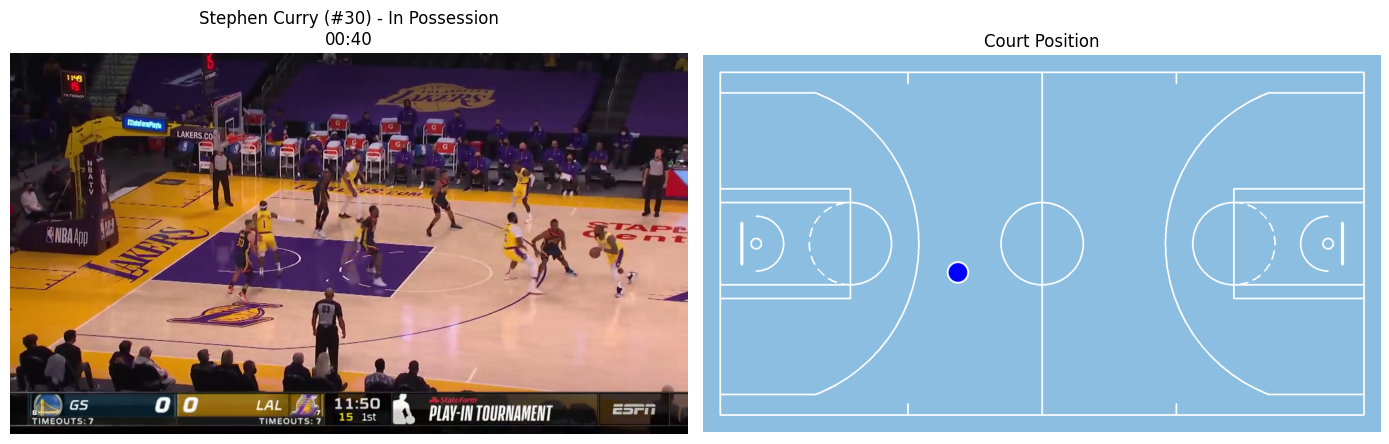

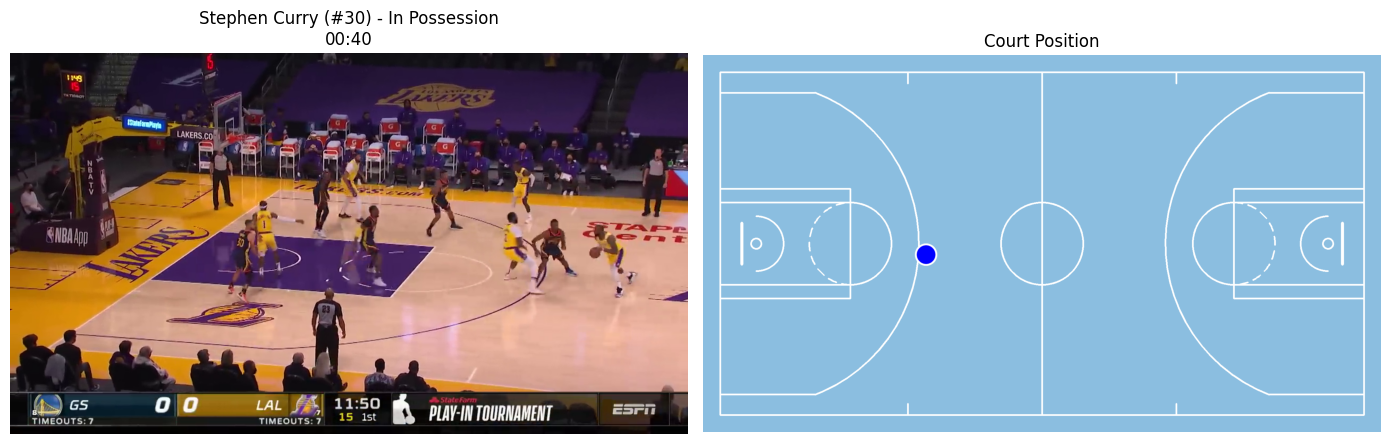

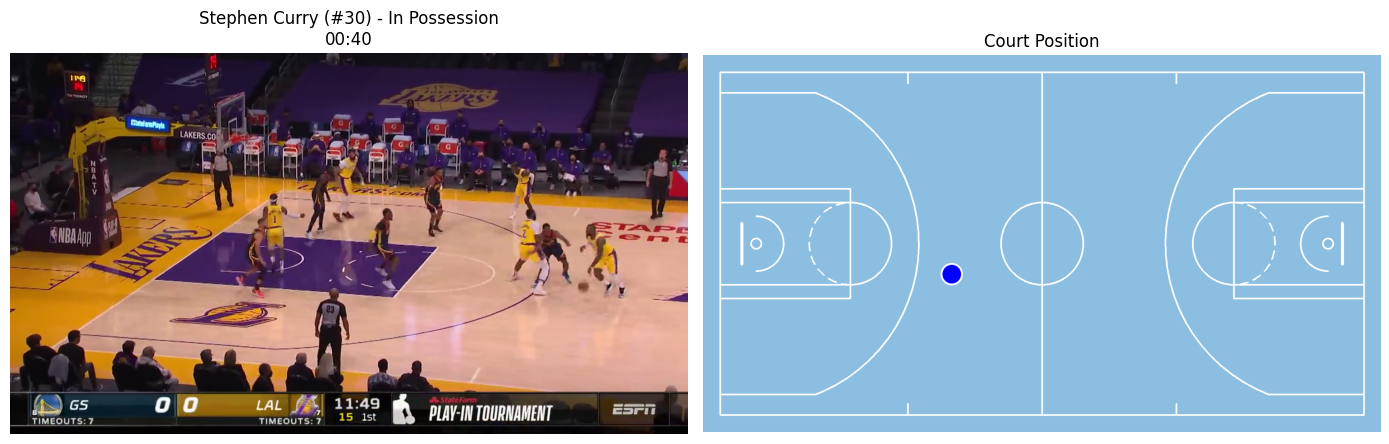

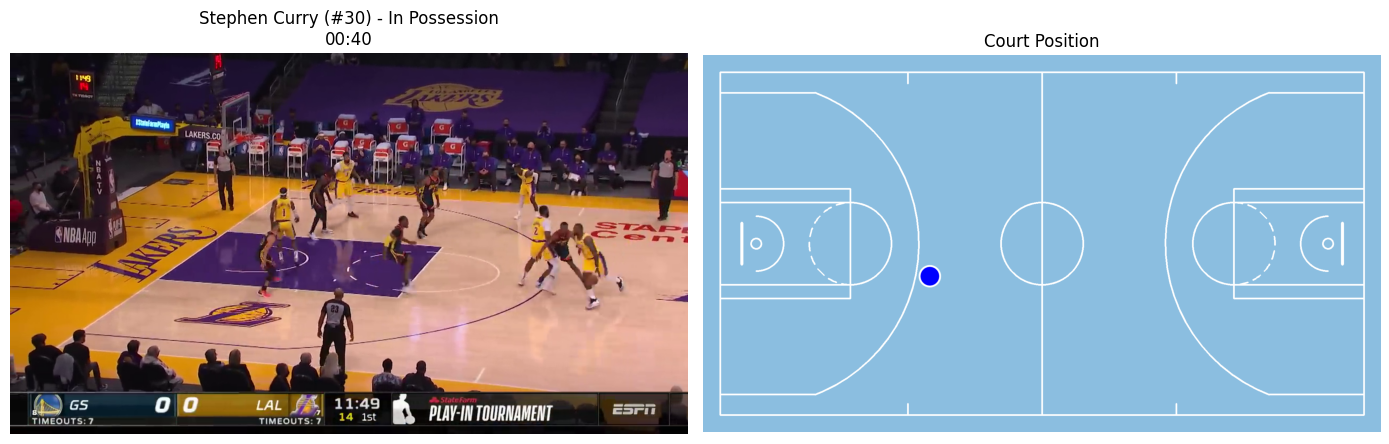

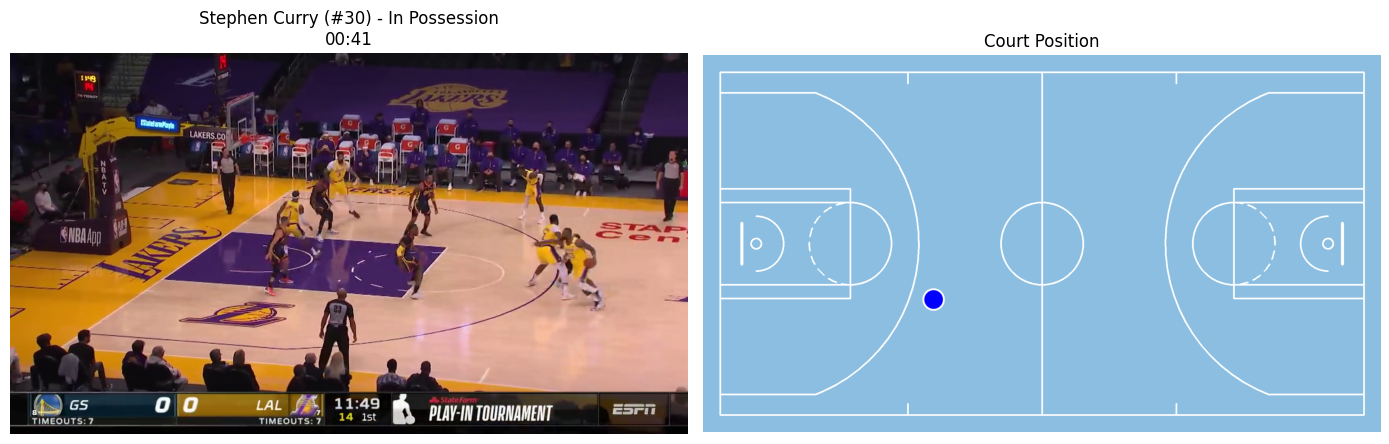

In [33]:
# Run Analysis on Plays
import matplotlib.pyplot as plt

TARGET_PLAYER = "Stephen Curry"

all_events = []
print(f"Looking for {TARGET_PLAYER}...")

# Analyze first 5 plays
for play in plays[:5]:
    events = analyze_play(TRIMMED_VIDEO_PATH, play, TARGET_PLAYER, TEAM_ROSTERS)
    if events:
        all_events.extend(events)

# Display results
if all_events:
    print(f"\n{'='*60}")
    print(f"RESULTS: Found {len(all_events)} actions by {TARGET_PLAYER}")
    print(f"{'='*60}\n")

    for i, event in enumerate(all_events[:5]):  # Show first 5
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Frame
        axes[0].imshow(cv2.cvtColor(event['frame'], cv2.COLOR_BGR2RGB))
        axes[0].set_title(f"{event['player']} (#{event['jersey_number']}) - {event['action']}\n{event['timestamp_formatted']}")
        axes[0].axis('off')

        # Court view
        if event['court_view'] is not None:
            axes[1].imshow(event['court_view'])
            axes[1].set_title("Court Position")
        else:
            axes[1].text(0.5, 0.5, "Court view unavailable", ha='center', va='center')
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()
else:
    print(f"\n⚠️ No actions found for {TARGET_PLAYER} in the analyzed plays.")
    print("Try: 1) Analyzing more plays, 2) Checking if player is in the video, 3) Lowering confidence thresholds")

In [34]:
# Generate Summary Table
import pandas as pd

if all_events:
    # Create DataFrame
    df = pd.DataFrame([{
        'Timestamp': e['timestamp_formatted'],
        'Player': e['player'],
        'Jersey #': e['jersey_number'],
        'Action': e['action']
    } for e in all_events])
    display(df)
else:
    print("No events to summarize.")

Timestamp         Player Jersey #         Action
0      00:40  Stephen Curry       30  In Possession
1      00:40  Stephen Curry       30  In Possession
2      00:40  Stephen Curry       30  In Possession
3      00:40  Stephen Curry       30  In Possession
4      00:41  Stephen Curry       30  In Possession
..       ...            ...      ...            ...
75     01:42  Stephen Curry       30  In Possession
76     01:42  Stephen Curry       30  In Possession
77     01:42  Stephen Curry       30  In Possession
78     01:43  Stephen Curry       30  In Possession
79     01:43  Stephen Curry       30  In Possession

[80 rows x 4 columns]

In [35]:
# Complete Bird's Eye View for Each Action

def generate_full_court_view(frame: np.ndarray, config: CourtConfiguration) -> np.ndarray:
    """
    Generate bird's eye view showing ALL players on court.
    """
    # Detect all players
    result = PLAYER_DETECTION_MODEL.infer(
        frame,
        confidence=PLAYER_DETECTION_MODEL_CONFIDENCE,
        iou_threshold=PLAYER_DETECTION_MODEL_IOU_THRESHOLD
    )[0]
    detections = sv.Detections.from_inference(result)
    player_detections = detections[np.isin(detections.class_id, PLAYER_CLASS_IDS)]

    if len(player_detections) == 0:
        return draw_court(config=config)

    # Detect court keypoints
    kp_result = KEYPOINT_DETECTION_MODEL.infer(
        frame,
        confidence=KEYPOINT_DETECTION_MODEL_CONFIDENCE
    )[0]
    key_points = sv.KeyPoints.from_inference(kp_result)
    landmarks_mask = key_points.confidence[0] > KEYPOINT_DETECTION_MODEL_ANCHOR_CONFIDENCE

    if np.count_nonzero(landmarks_mask) < 4:
        return draw_court(config=config)

    # Create transformer
    court_landmarks = np.array(config.vertices)[landmarks_mask]
    frame_landmarks = key_points[:, landmarks_mask].xy[0]
    transformer = ViewTransformer(source=frame_landmarks, target=court_landmarks)

    # Get feet positions for all players
    feet_positions = player_detections.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER)
    court_positions = transformer.transform_points(feet_positions)

    # Try to classify teams
    try:
        boxes = sv.scale_boxes(xyxy=player_detections.xyxy, factor=0.4)
        crops = [sv.crop_image(frame, box) for box in boxes]
        teams = np.array(team_classifier.predict(crops))
    except:
        teams = np.zeros(len(player_detections))

    # Draw court with all players
    court = draw_court(config=config)

    # Draw team 0 (e.g., Warriors)
    team_0_mask = teams == 0
    if np.any(team_0_mask):
        court = draw_points_on_court(
            config=config,
            xy=court_positions[team_0_mask],
            fill_color=sv.Color.BLUE,
            court=court
        )

    # Draw team 1 (e.g., Lakers)
    team_1_mask = teams == 1
    if np.any(team_1_mask):
        court = draw_points_on_court(
            config=config,
            xy=court_positions[team_1_mask],
            fill_color=sv.Color.from_hex("#FDB927"),  # Lakers gold
            court=court
        )

    return court

600it [00:27, 21.55it/s]


Collected 4174 crops


config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/813M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Embedding extraction: 131it [00:18,  7.02it/s]
Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7ca64af49800>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/ctypes/__init__.py", line 379, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error


✅ Team classifier trained


Embedding extraction: 4it [00:00,  8.07it/s]


Team 0 samples:


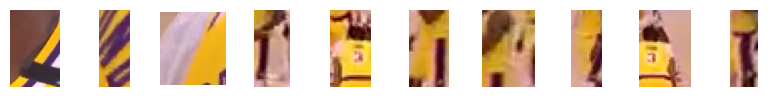

Team 1 samples:


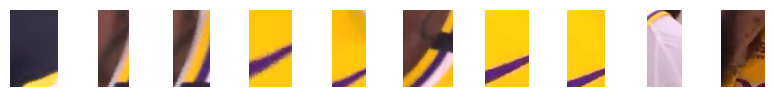

In [36]:
# --- CELL 15: Train Team Classifier ---

# Collect crops from video for team classification
STRIDE = 30
crops_for_training = []

frame_generator = sv.get_video_frames_generator(source_path=TRIMMED_VIDEO_PATH, stride=STRIDE)

print("Collecting player crops for team classification...")
for frame in tqdm(frame_generator):
    result = PLAYER_DETECTION_MODEL.infer(
        frame,
        confidence=PLAYER_DETECTION_MODEL_CONFIDENCE,
        iou_threshold=PLAYER_DETECTION_MODEL_IOU_THRESHOLD,
        class_agnostic_nms=True
    )[0]
    detections = sv.Detections.from_inference(result)
    detections = detections[np.isin(detections.class_id, PLAYER_CLASS_IDS)]

    boxes = sv.scale_boxes(xyxy=detections.xyxy, factor=0.4)
    for box in boxes:
        crops_for_training.append(sv.crop_image(frame, box))

print(f"Collected {len(crops_for_training)} crops")

# Train classifier
team_classifier = TeamClassifier(device="cuda")
team_classifier.fit(crops_for_training)
print("✅ Team classifier trained")

# Visualize to verify
teams = team_classifier.predict(crops_for_training[:100])
team_0 = [crop for crop, team in zip(crops_for_training[:100], teams) if team == 0]
team_1 = [crop for crop, team in zip(crops_for_training[:100], teams) if team == 1]

print("Team 0 samples:")
sv.plot_images_grid(images=team_0[:10], grid_size=(1, 10), size=(10, 1))
print("Team 1 samples:")
sv.plot_images_grid(images=team_1[:10], grid_size=(1, 10), size=(10, 1))

Regenerating events with complete bird's eye views...


Embedding extraction: 1it [00:00, 21.49it/s]
Embedding extraction: 1it [00:00, 22.23it/s]
Embedding extraction: 1it [00:00, 24.13it/s]
Embedding extraction: 1it [00:00, 24.77it/s]
Embedding extraction: 1it [00:00, 19.24it/s]
Embedding extraction: 1it [00:00, 17.90it/s]
Embedding extraction: 1it [00:00, 18.33it/s]
Embedding extraction: 1it [00:00, 18.20it/s]
Embedding extraction: 1it [00:00, 18.12it/s]
Embedding extraction: 1it [00:00, 18.15it/s]
Embedding extraction: 1it [00:00, 18.33it/s]
Embedding extraction: 1it [00:00, 18.34it/s]
Embedding extraction: 1it [00:00, 19.53it/s]
Embedding extraction: 1it [00:00, 19.45it/s]
Embedding extraction: 1it [00:00, 18.25it/s]
Embedding extraction: 1it [00:00, 18.14it/s]
Embedding extraction: 1it [00:00, 25.07it/s]



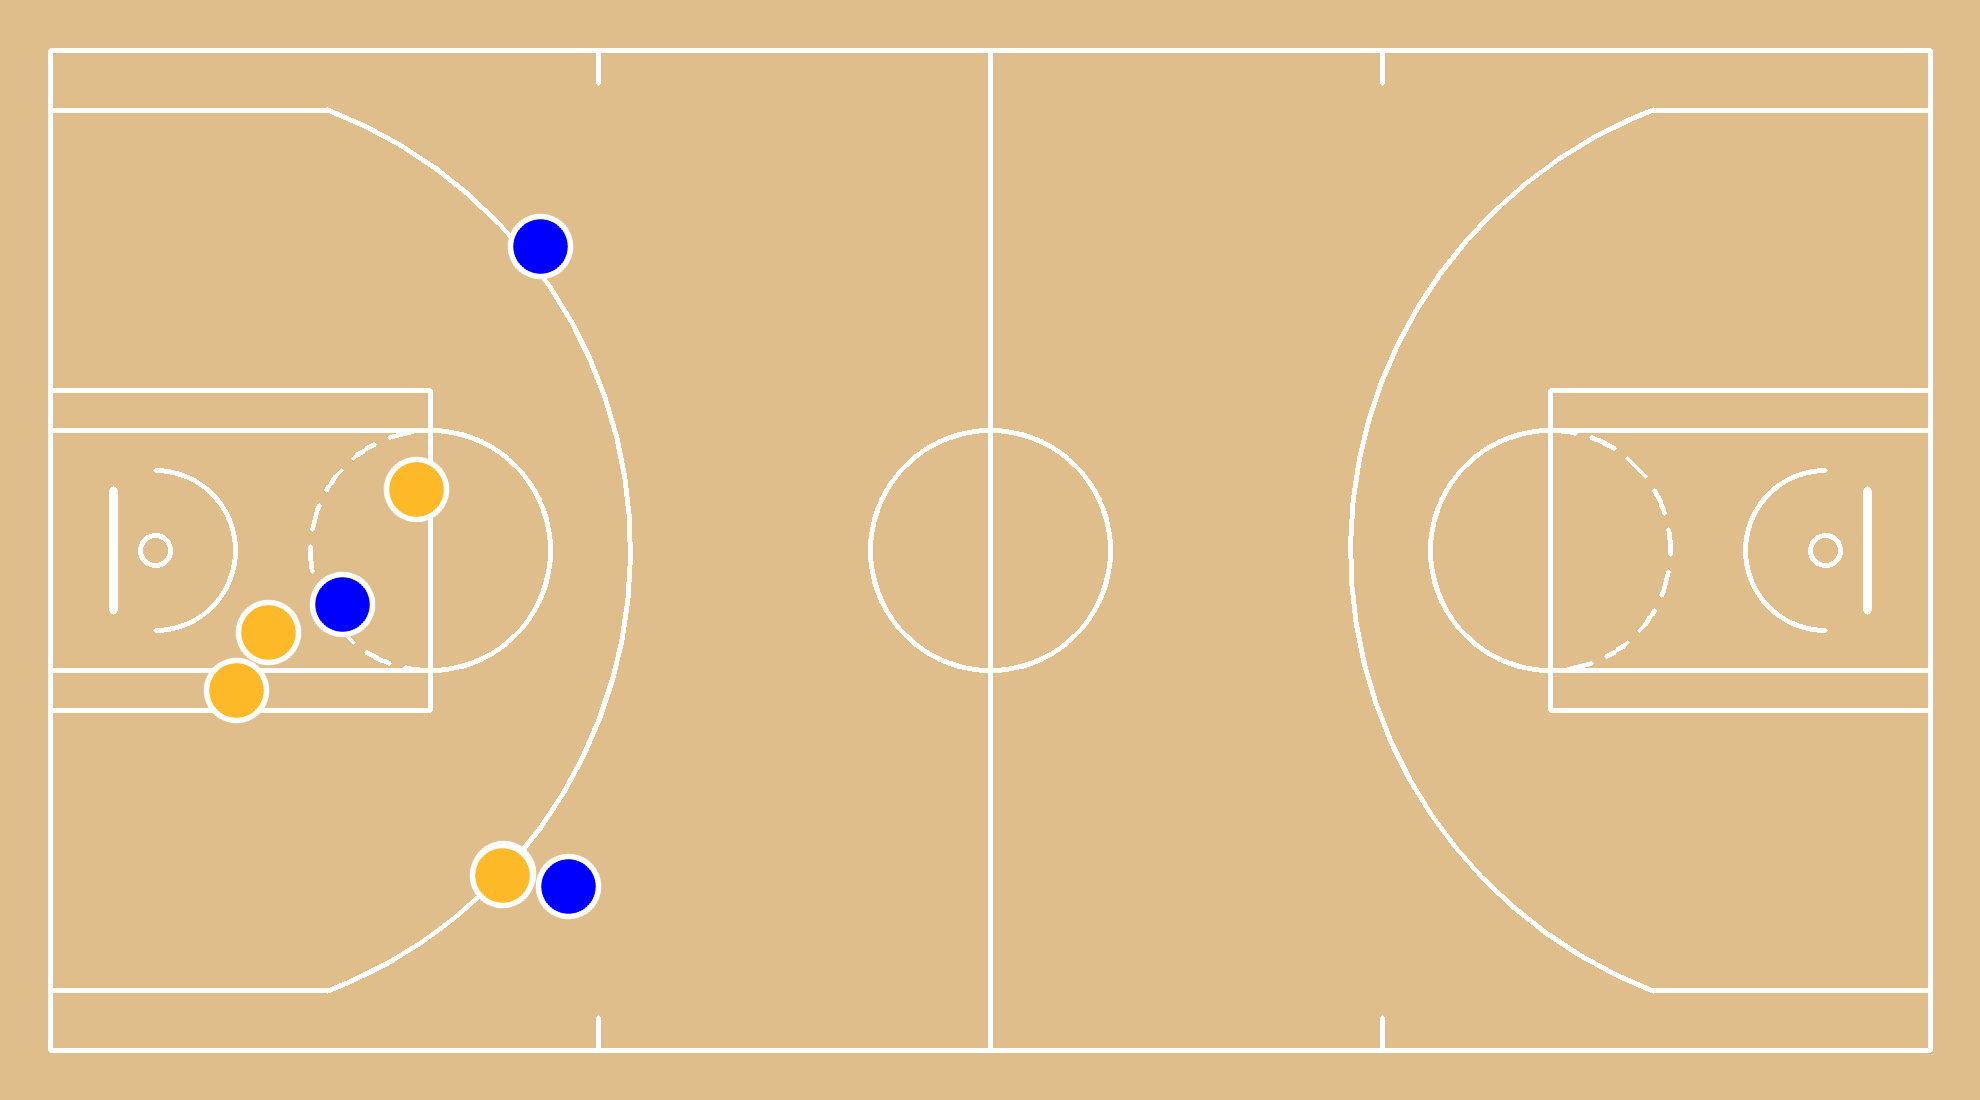
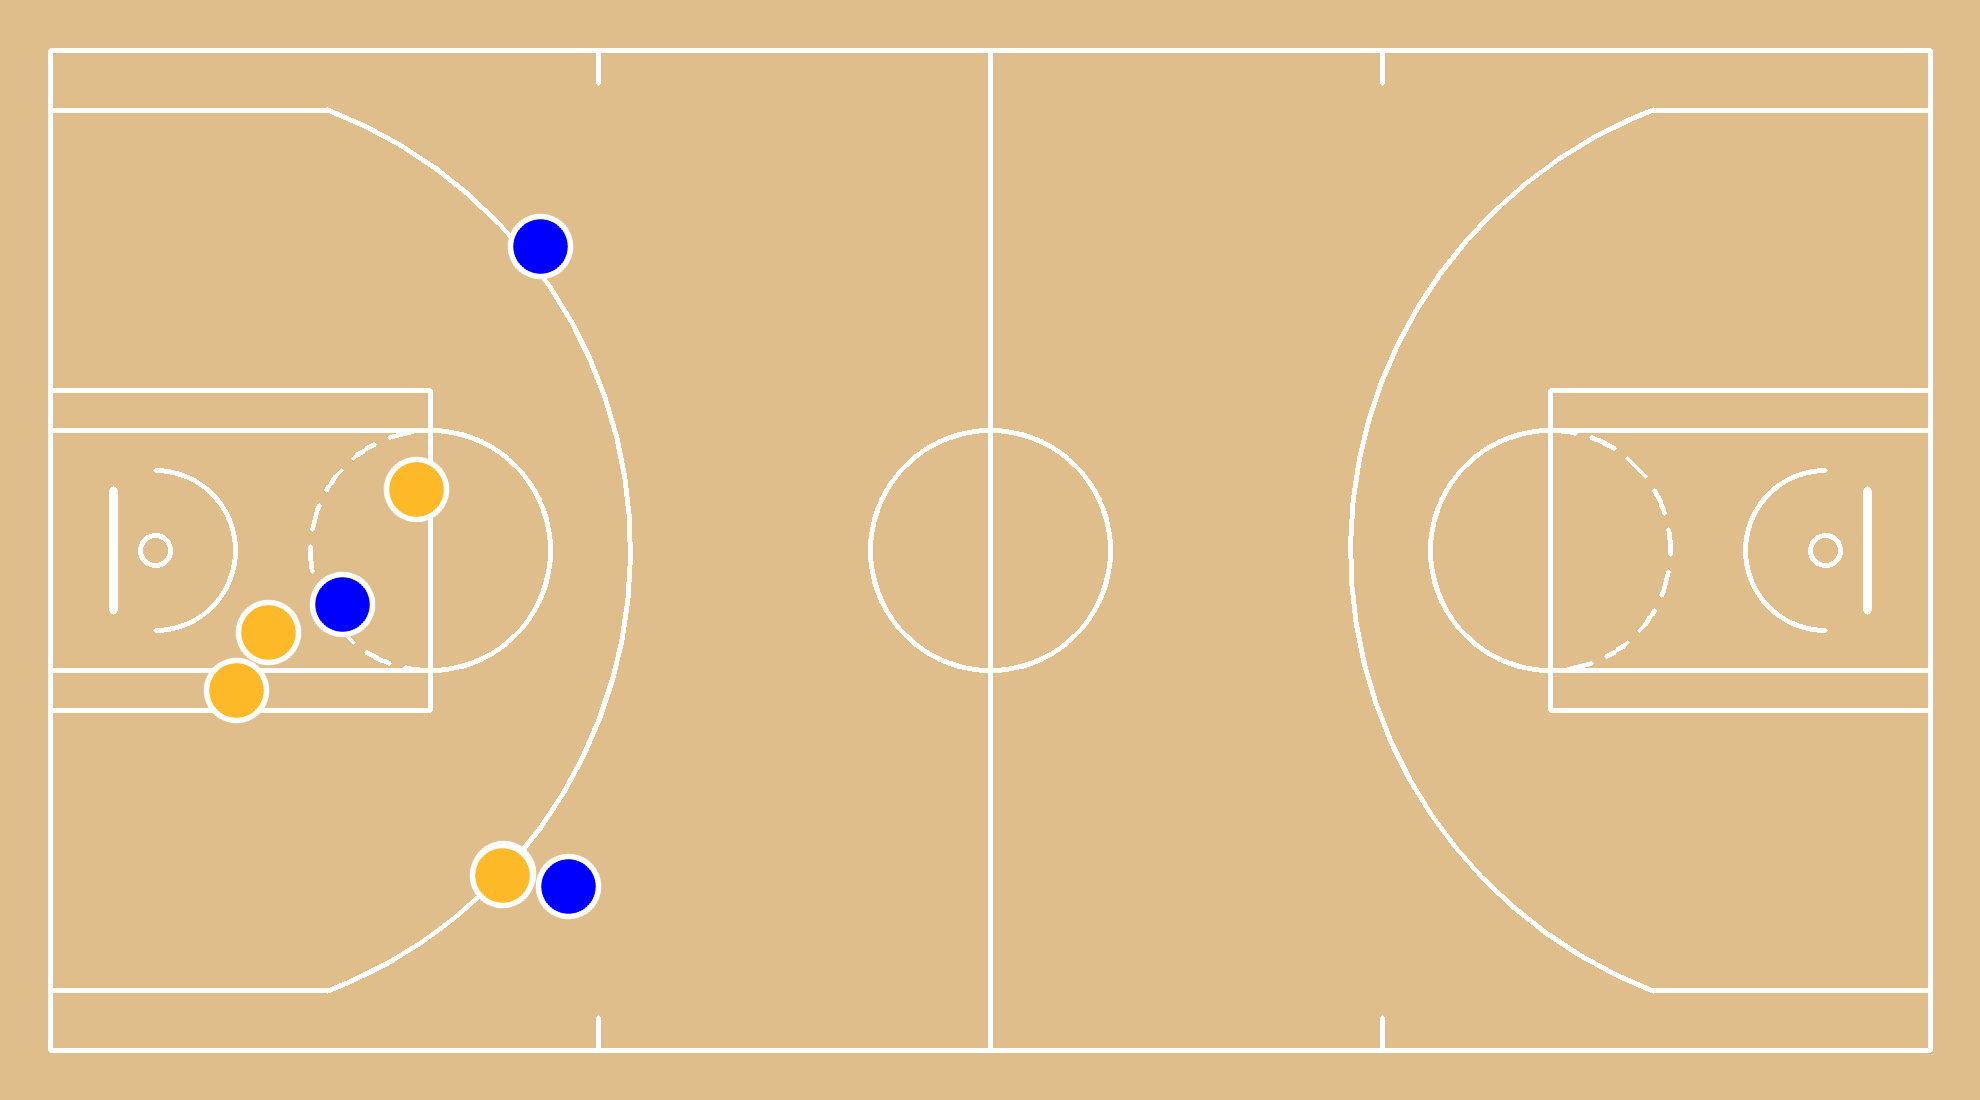
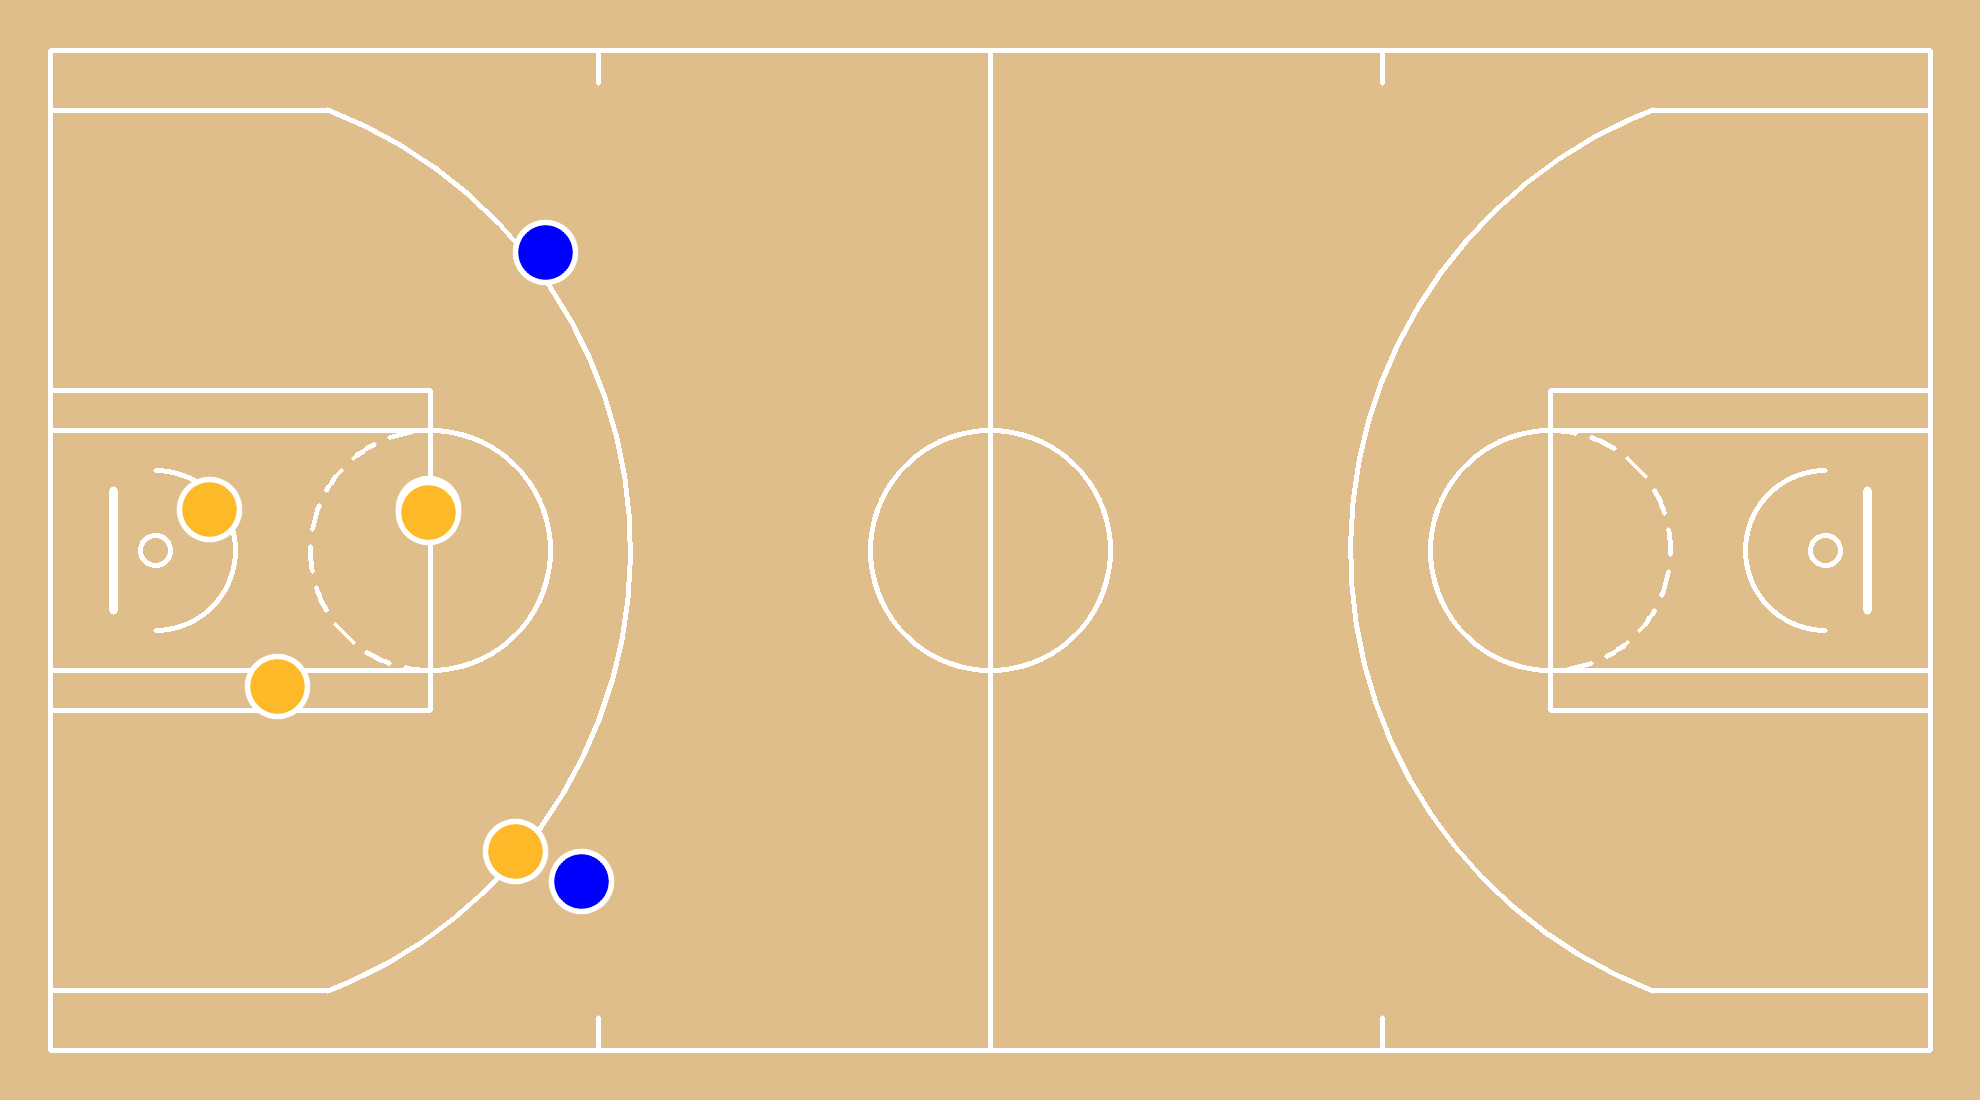
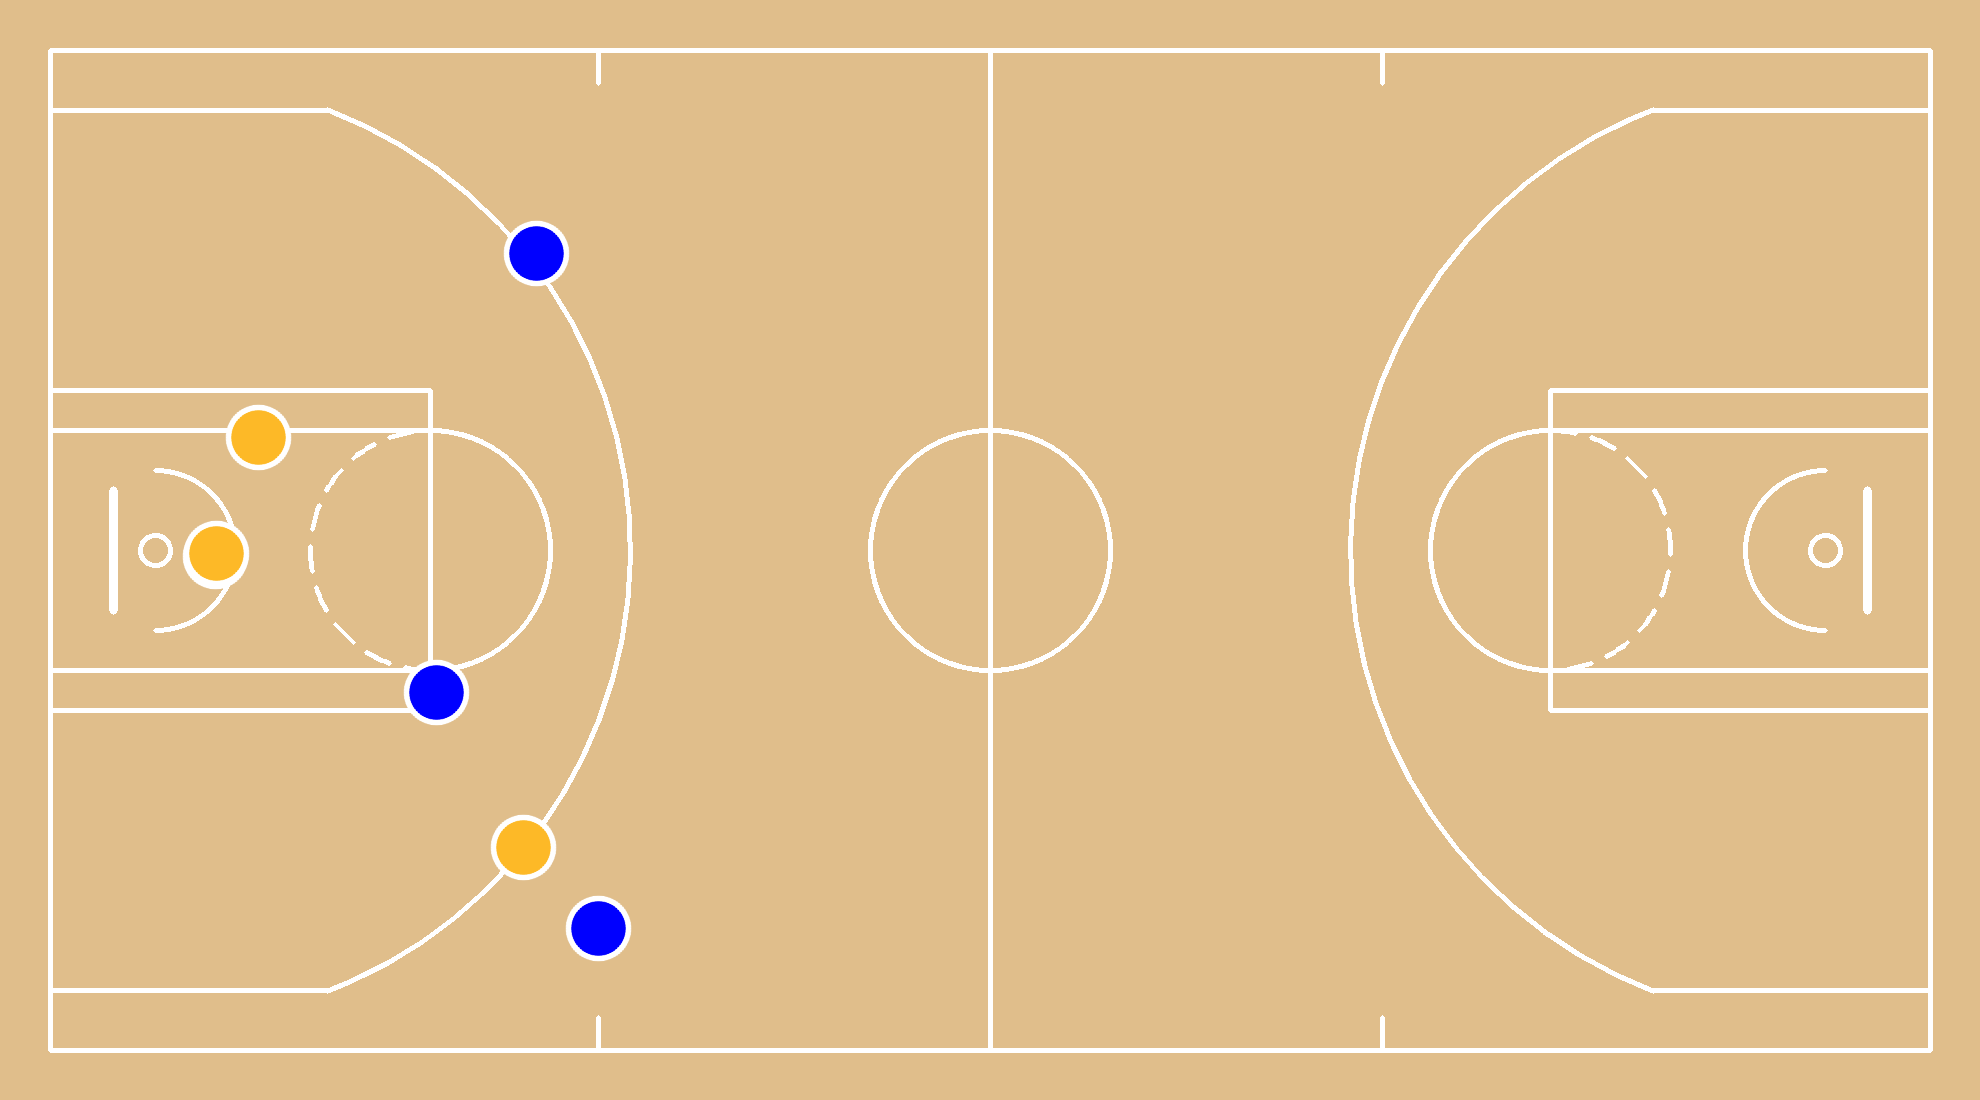
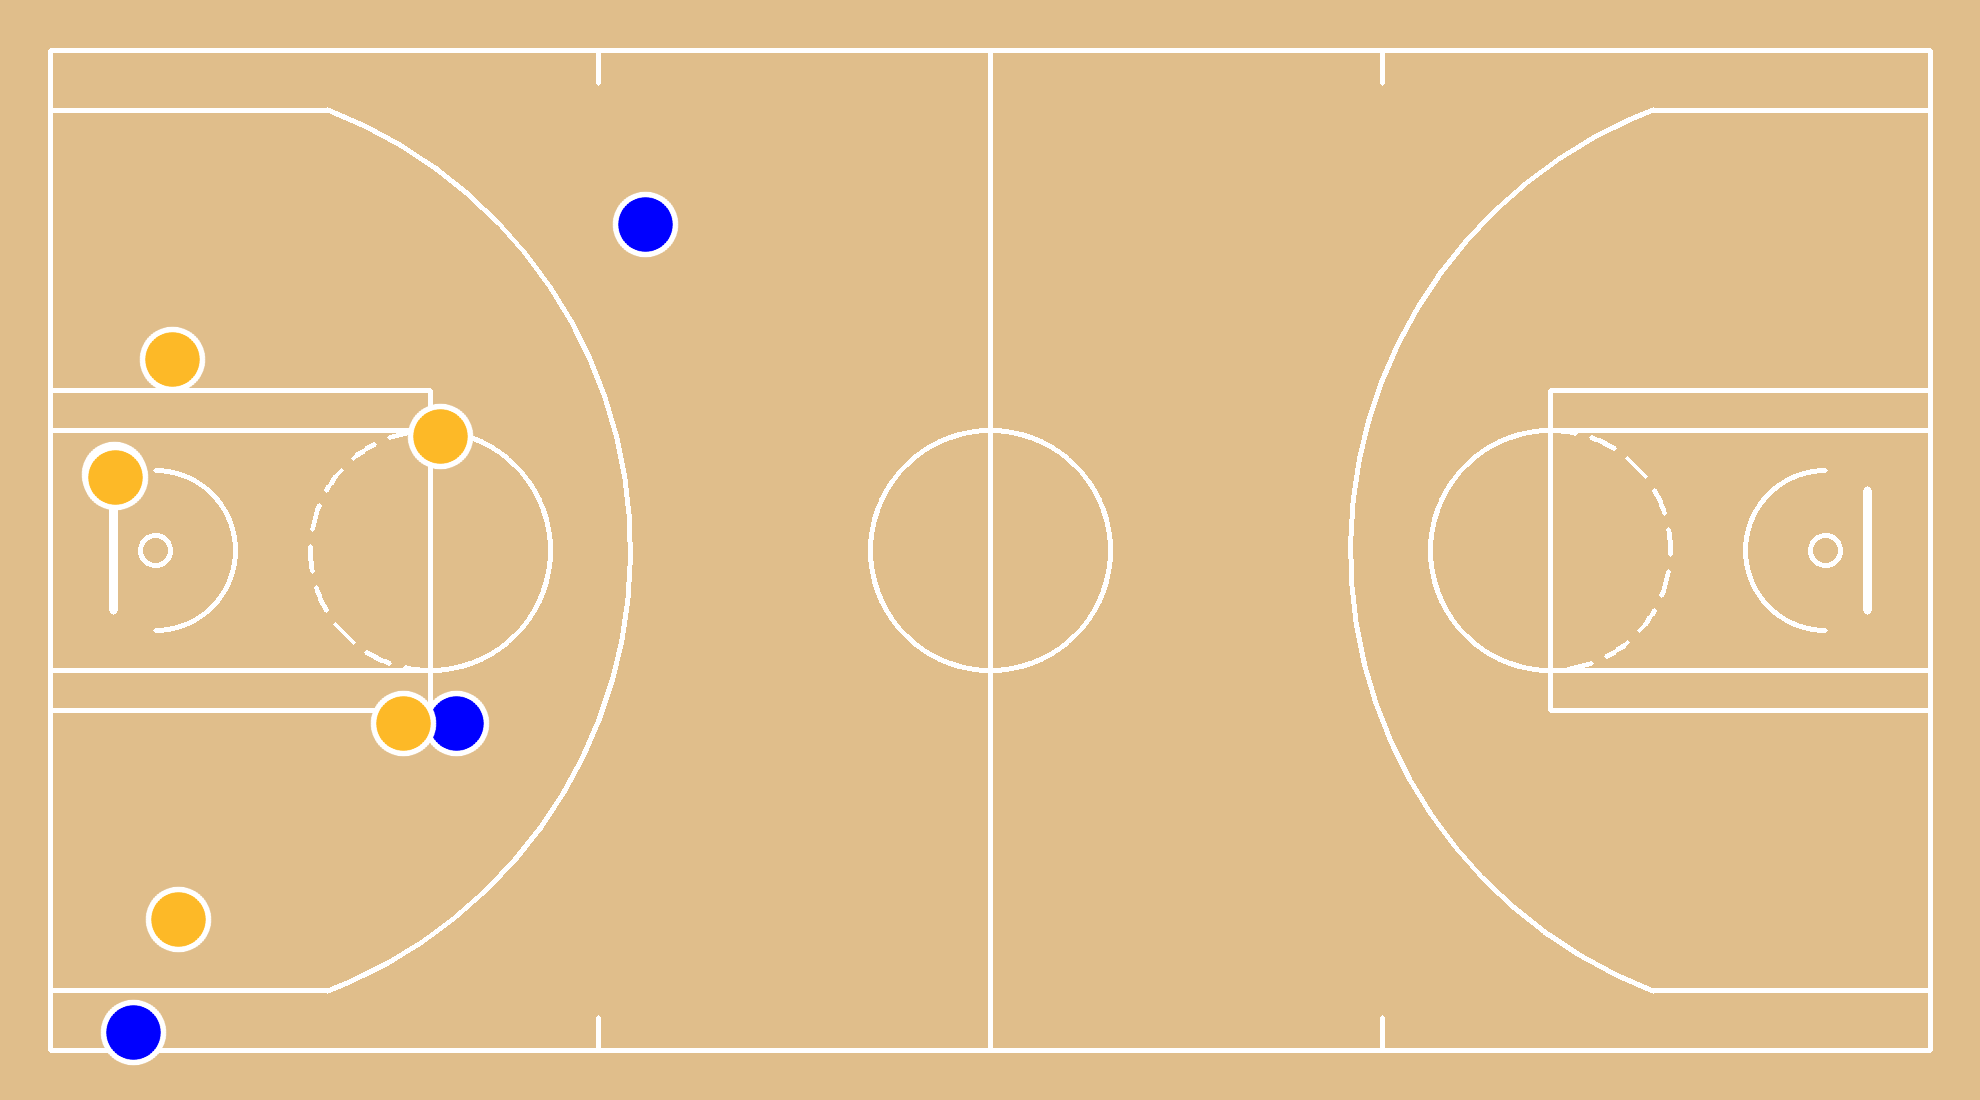
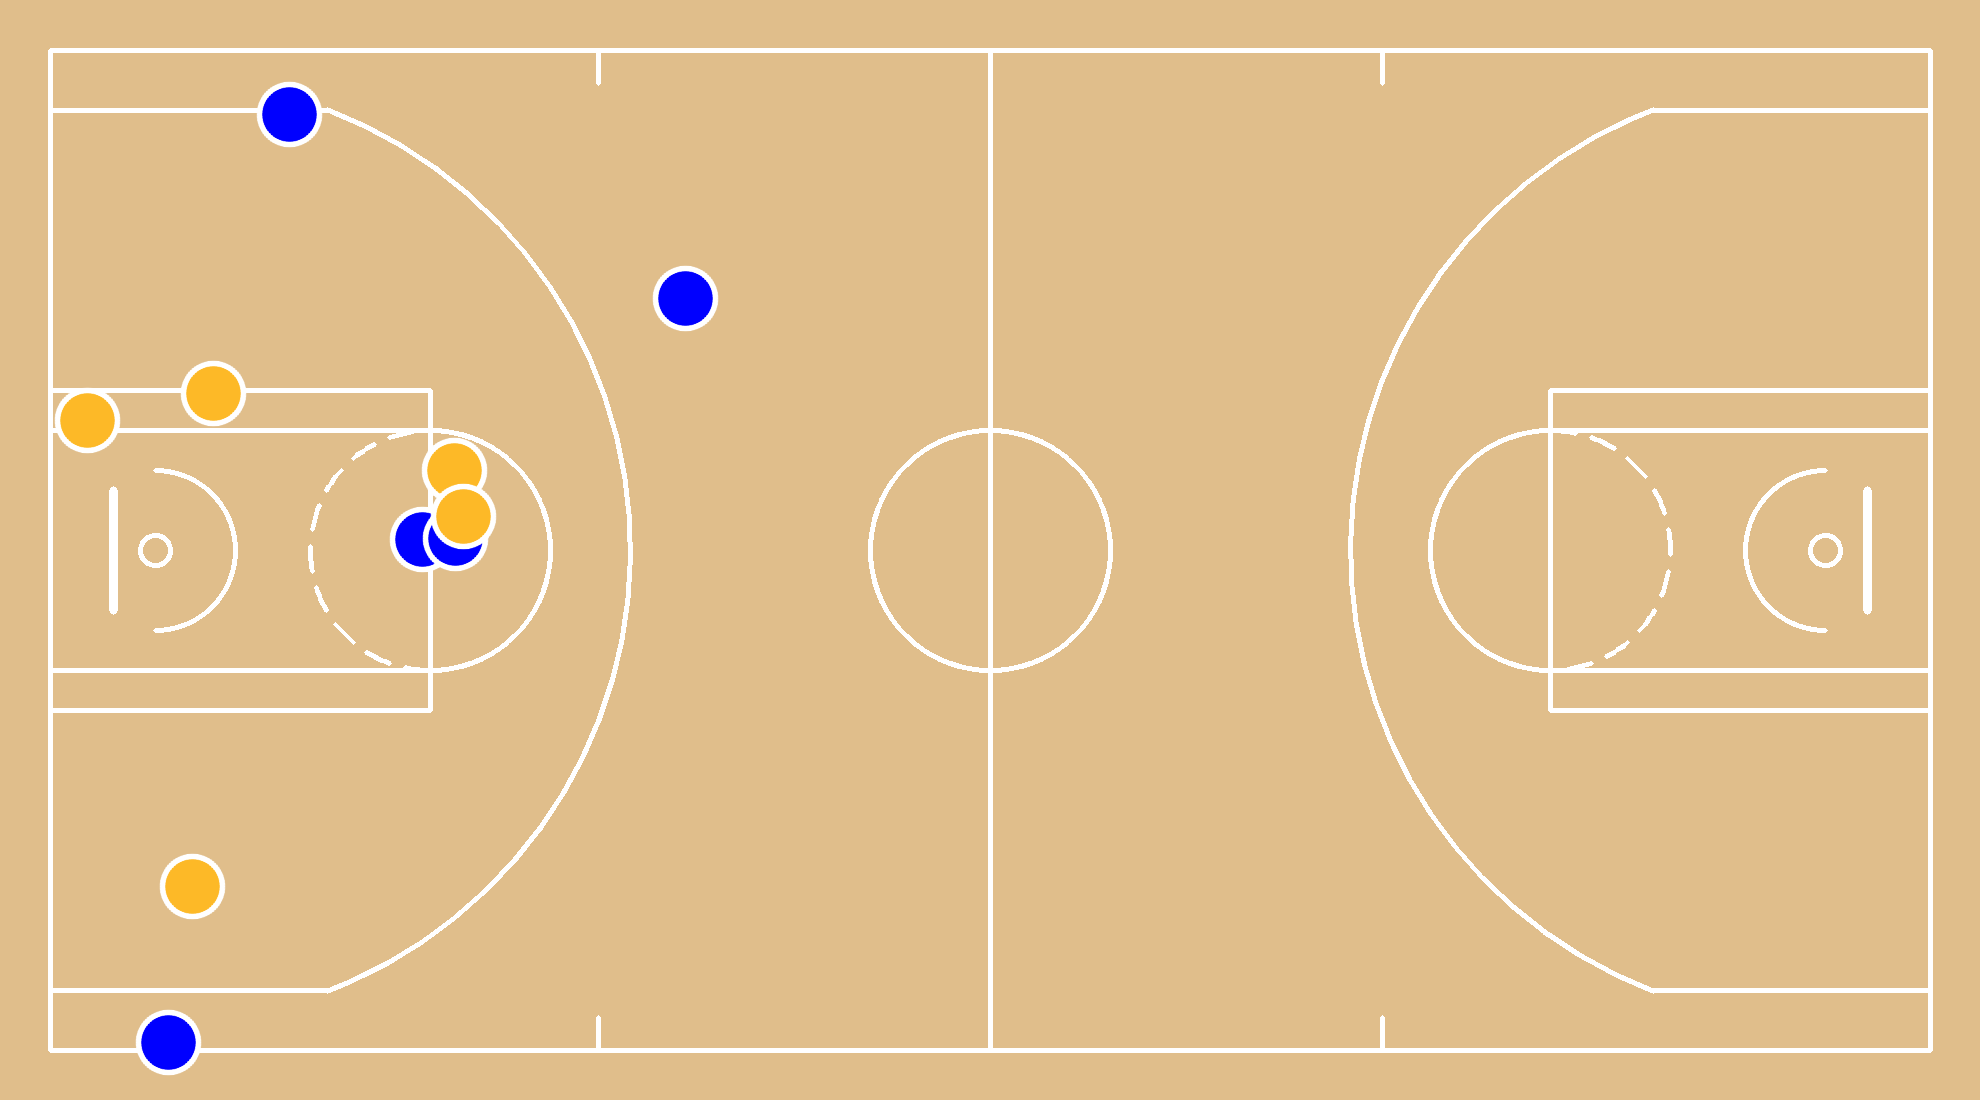
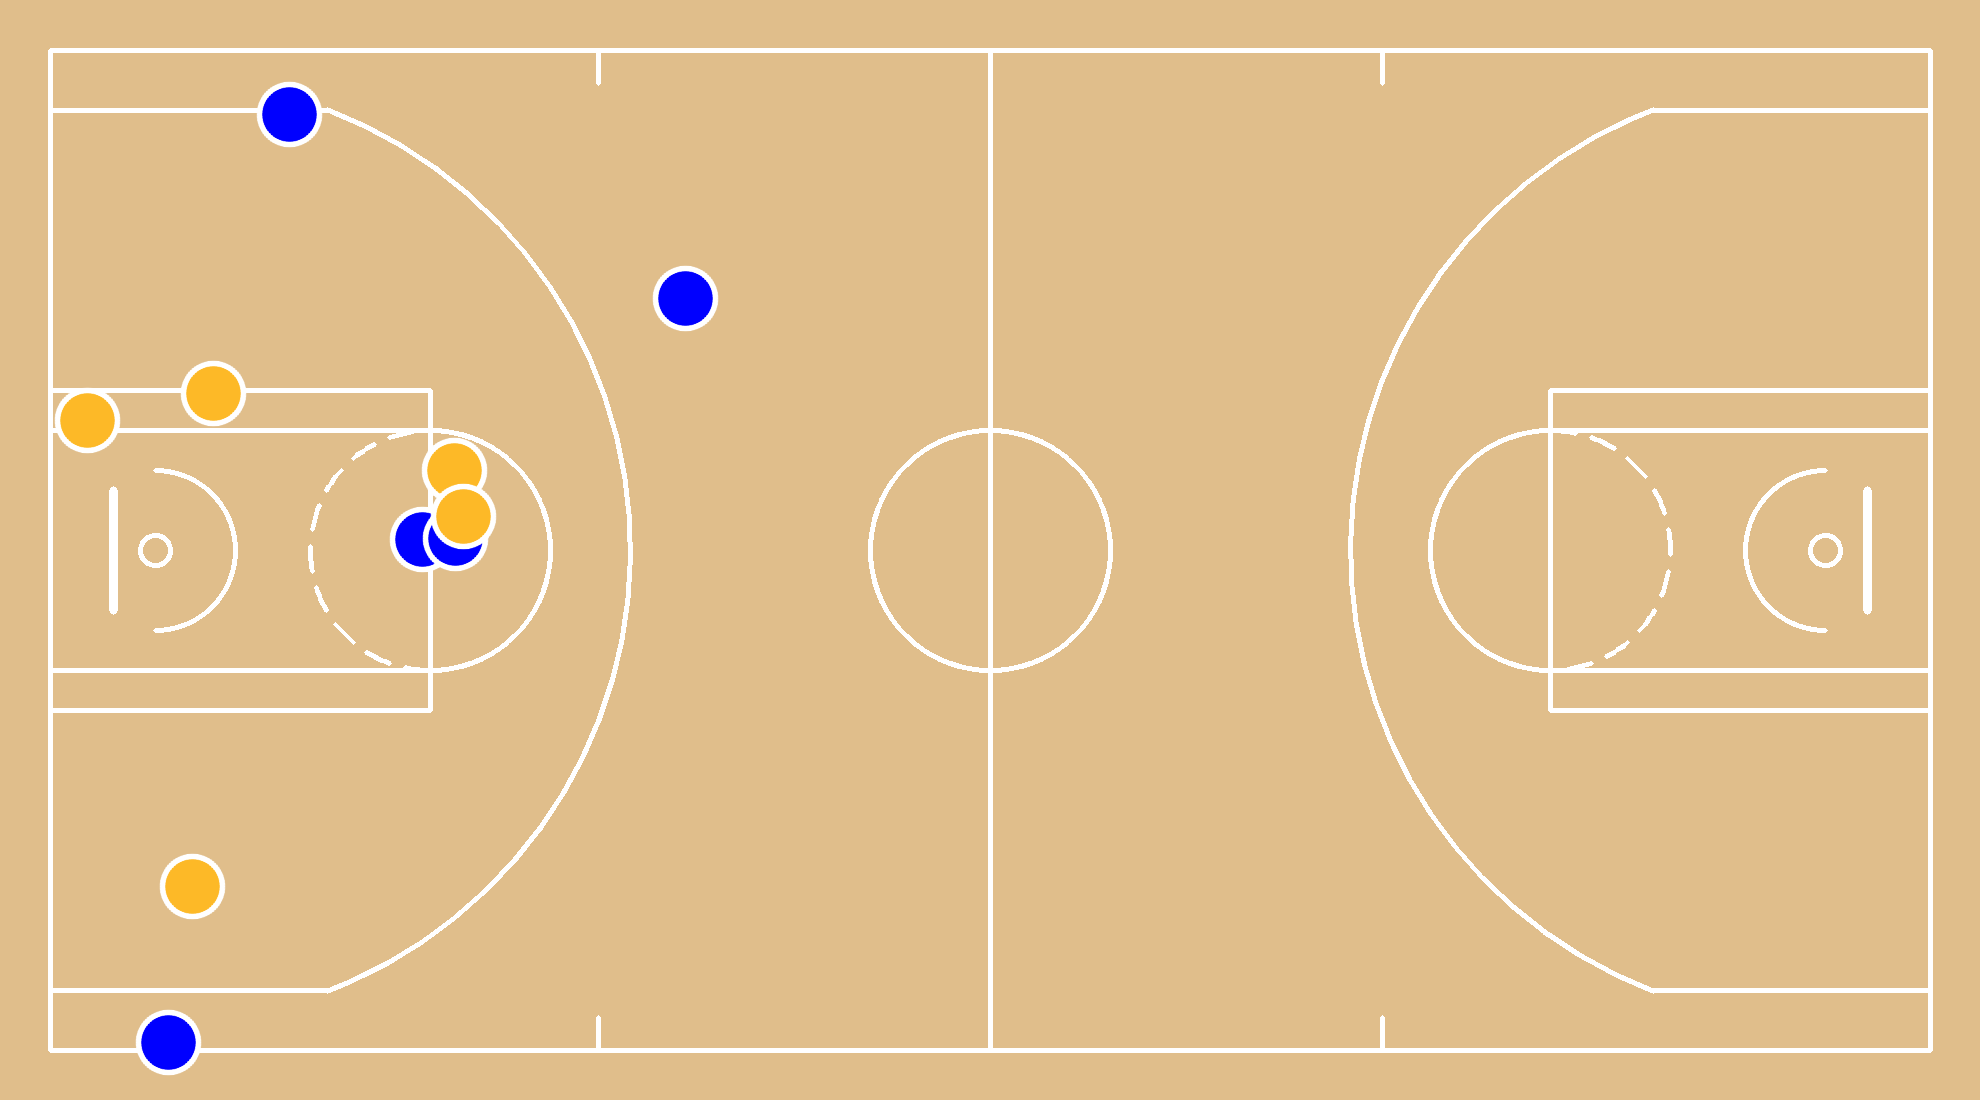
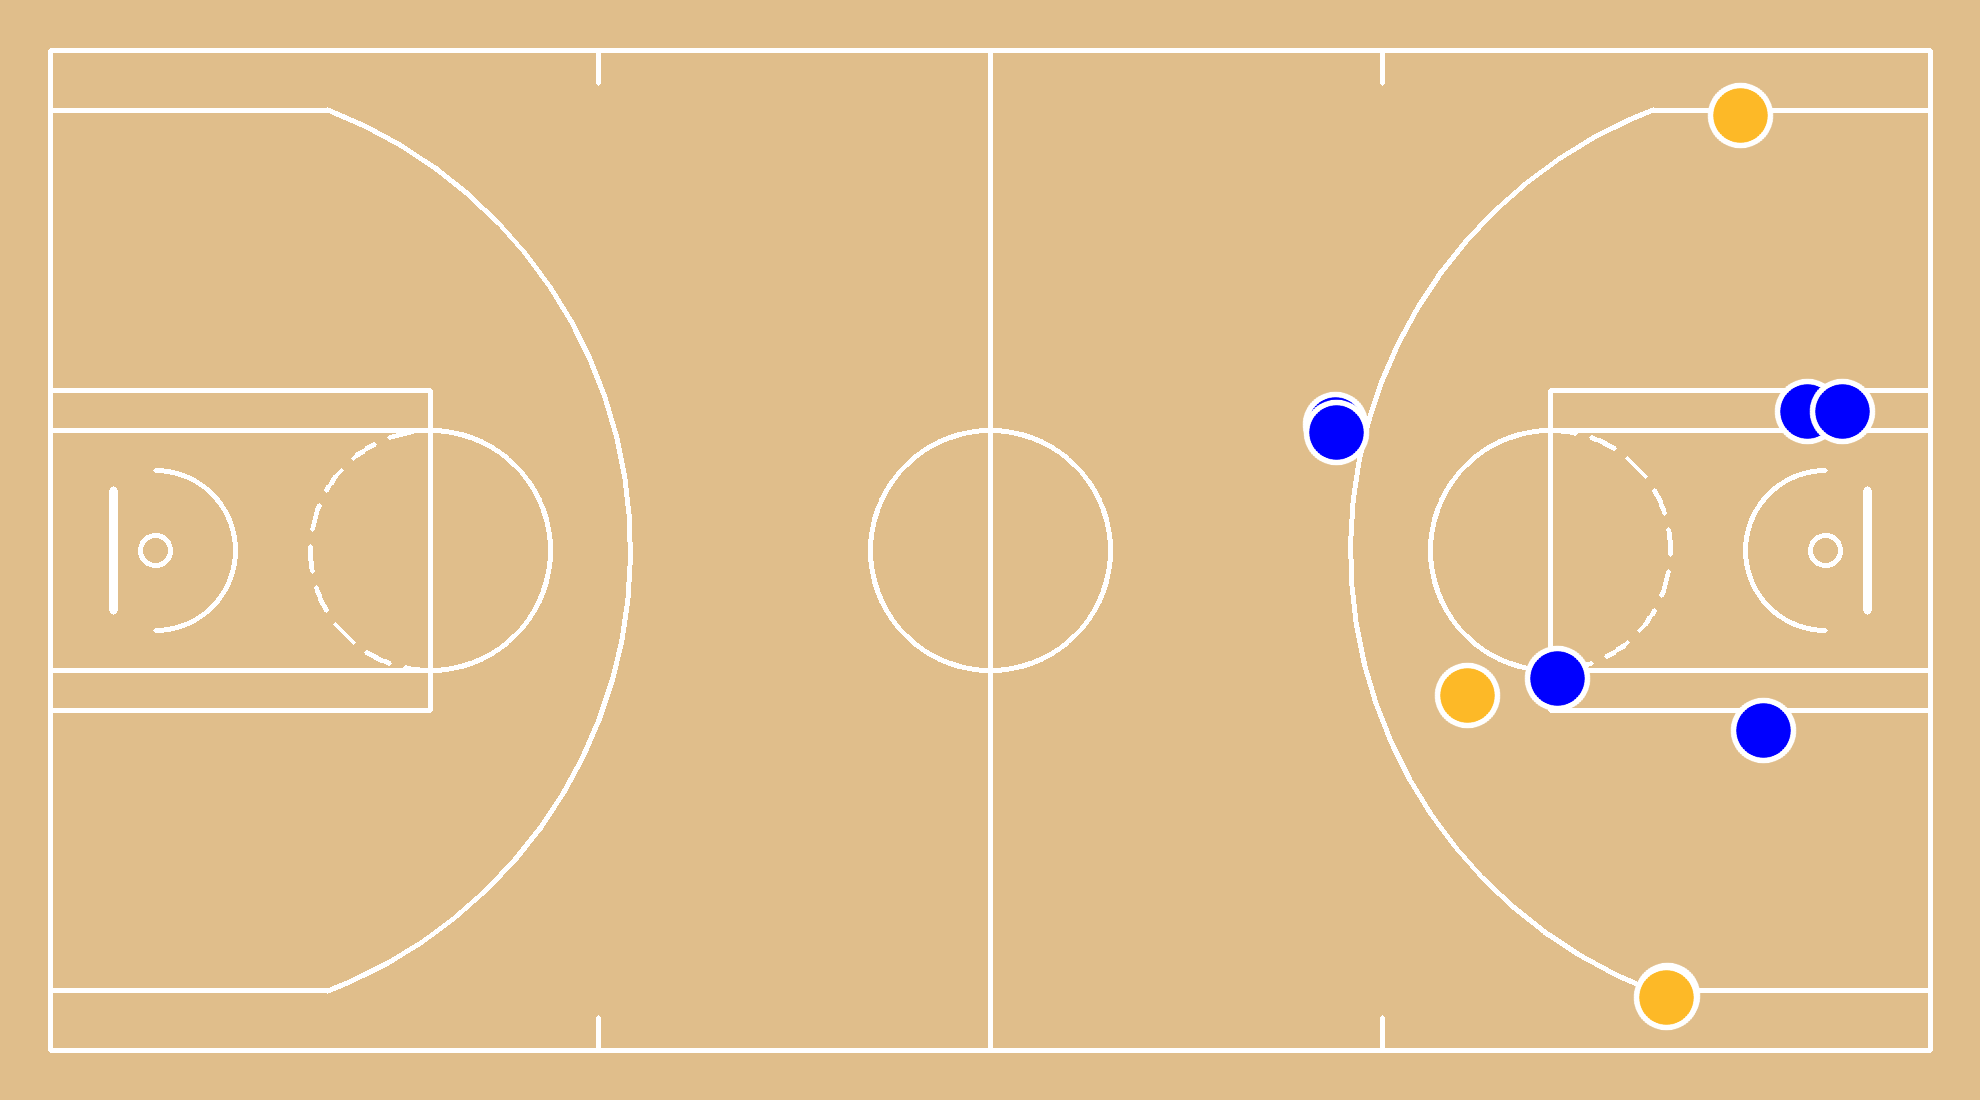
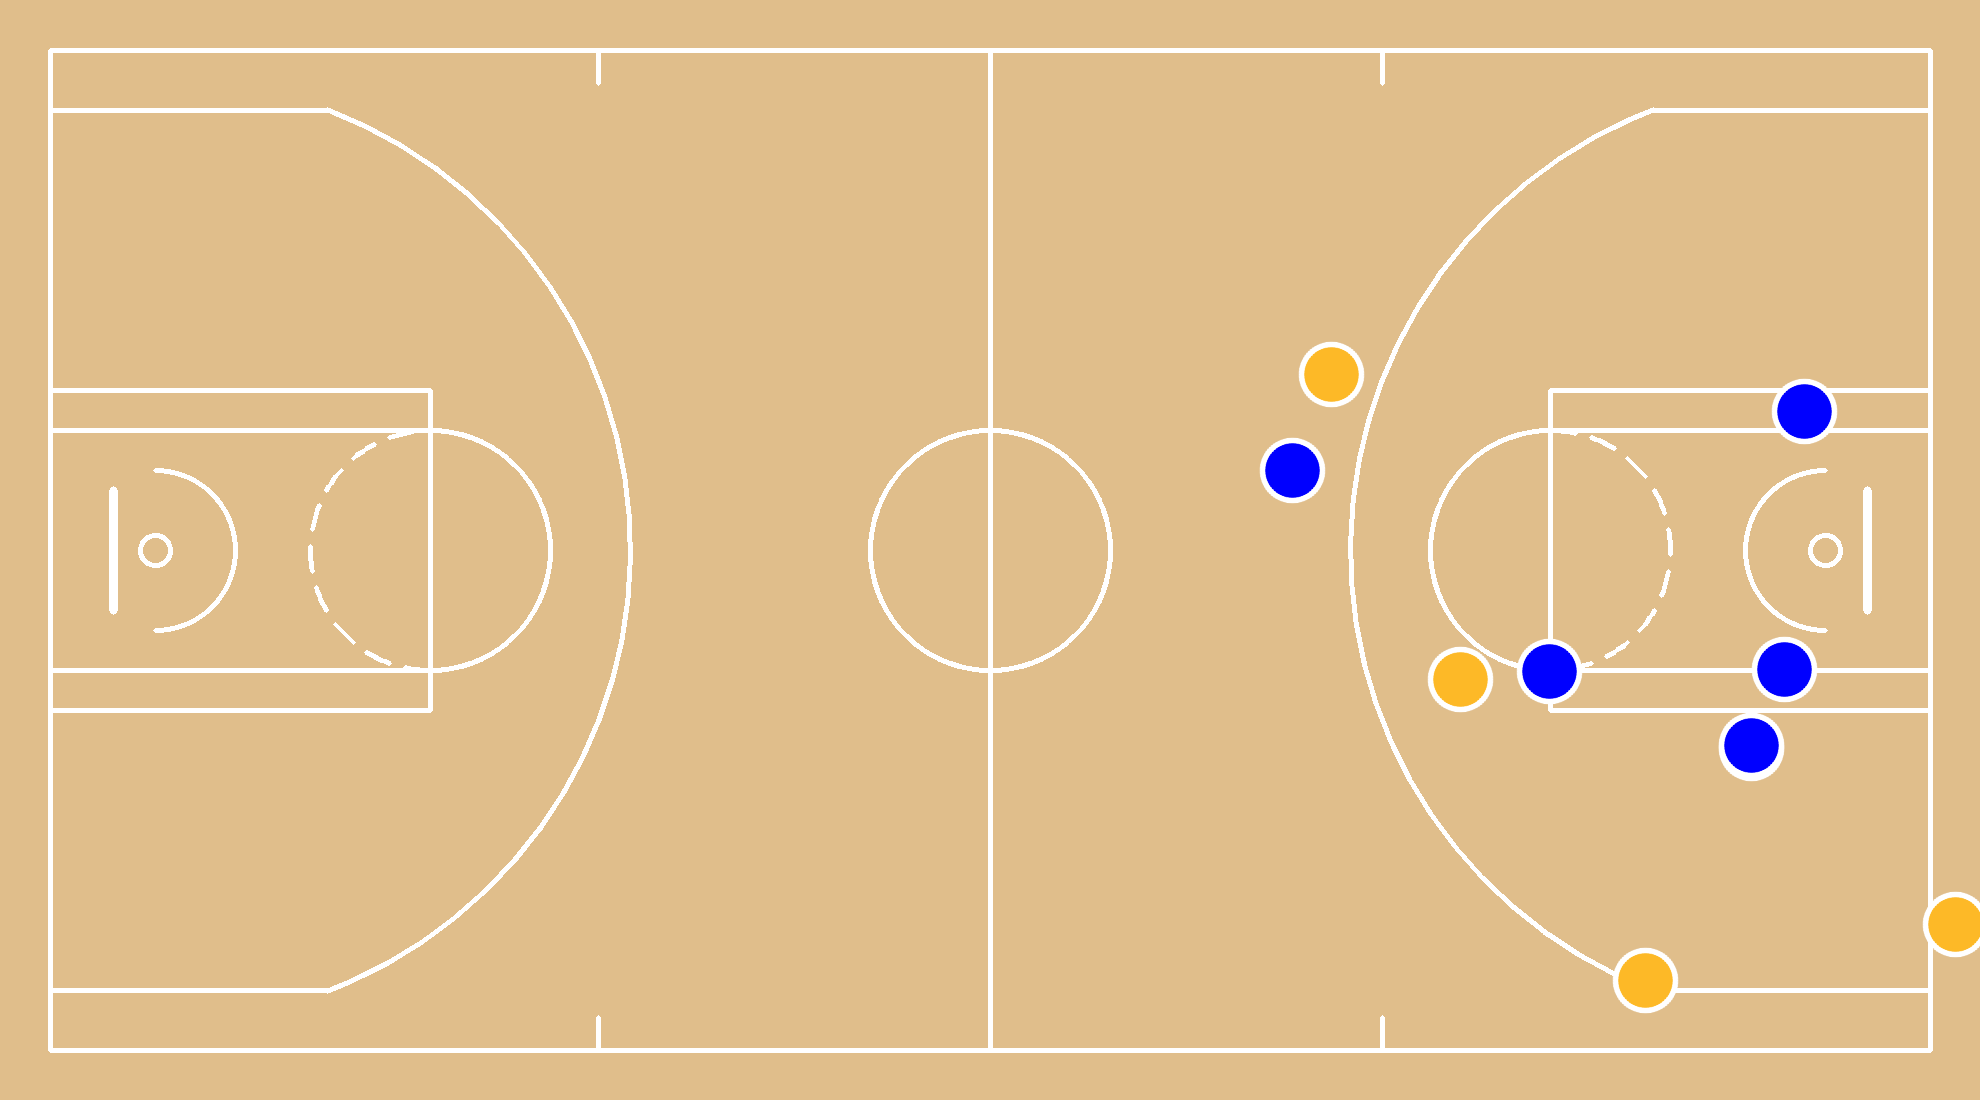
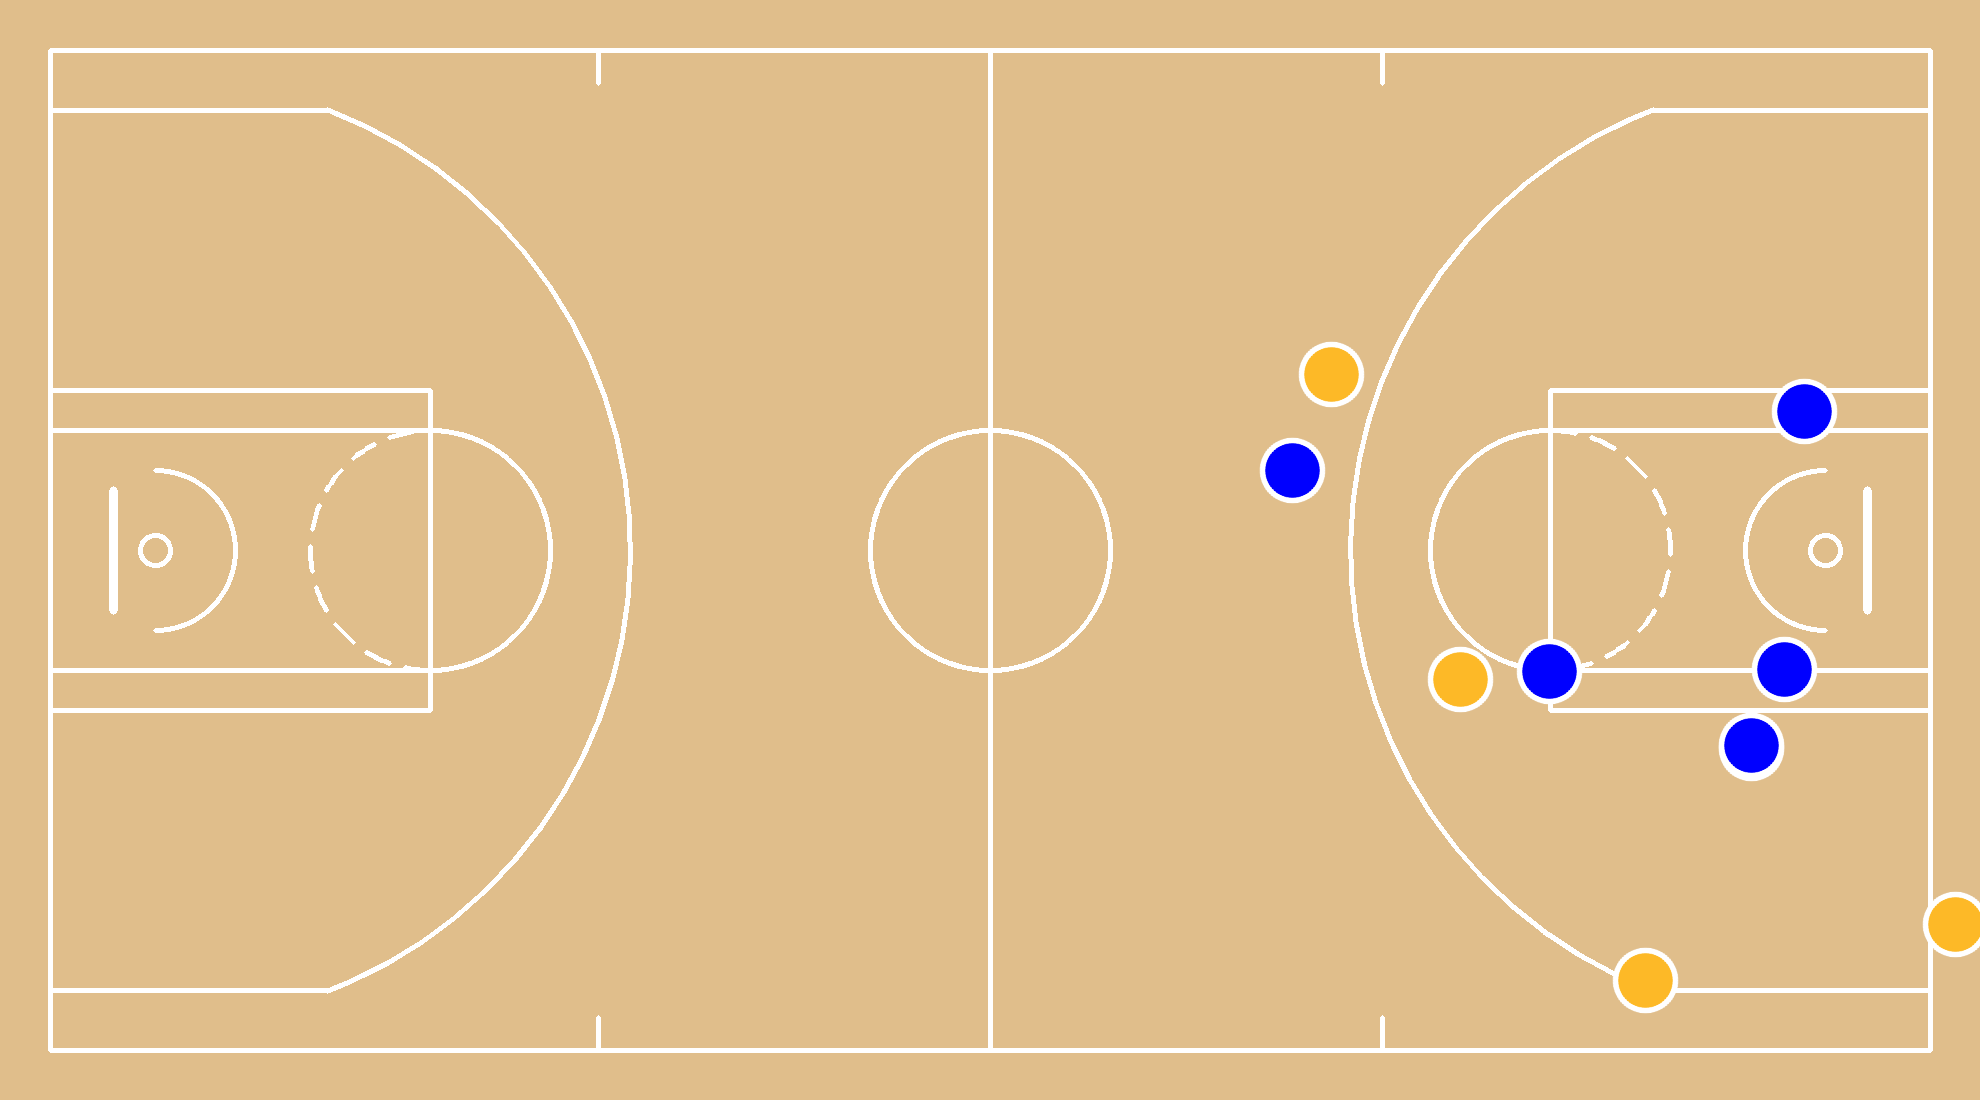
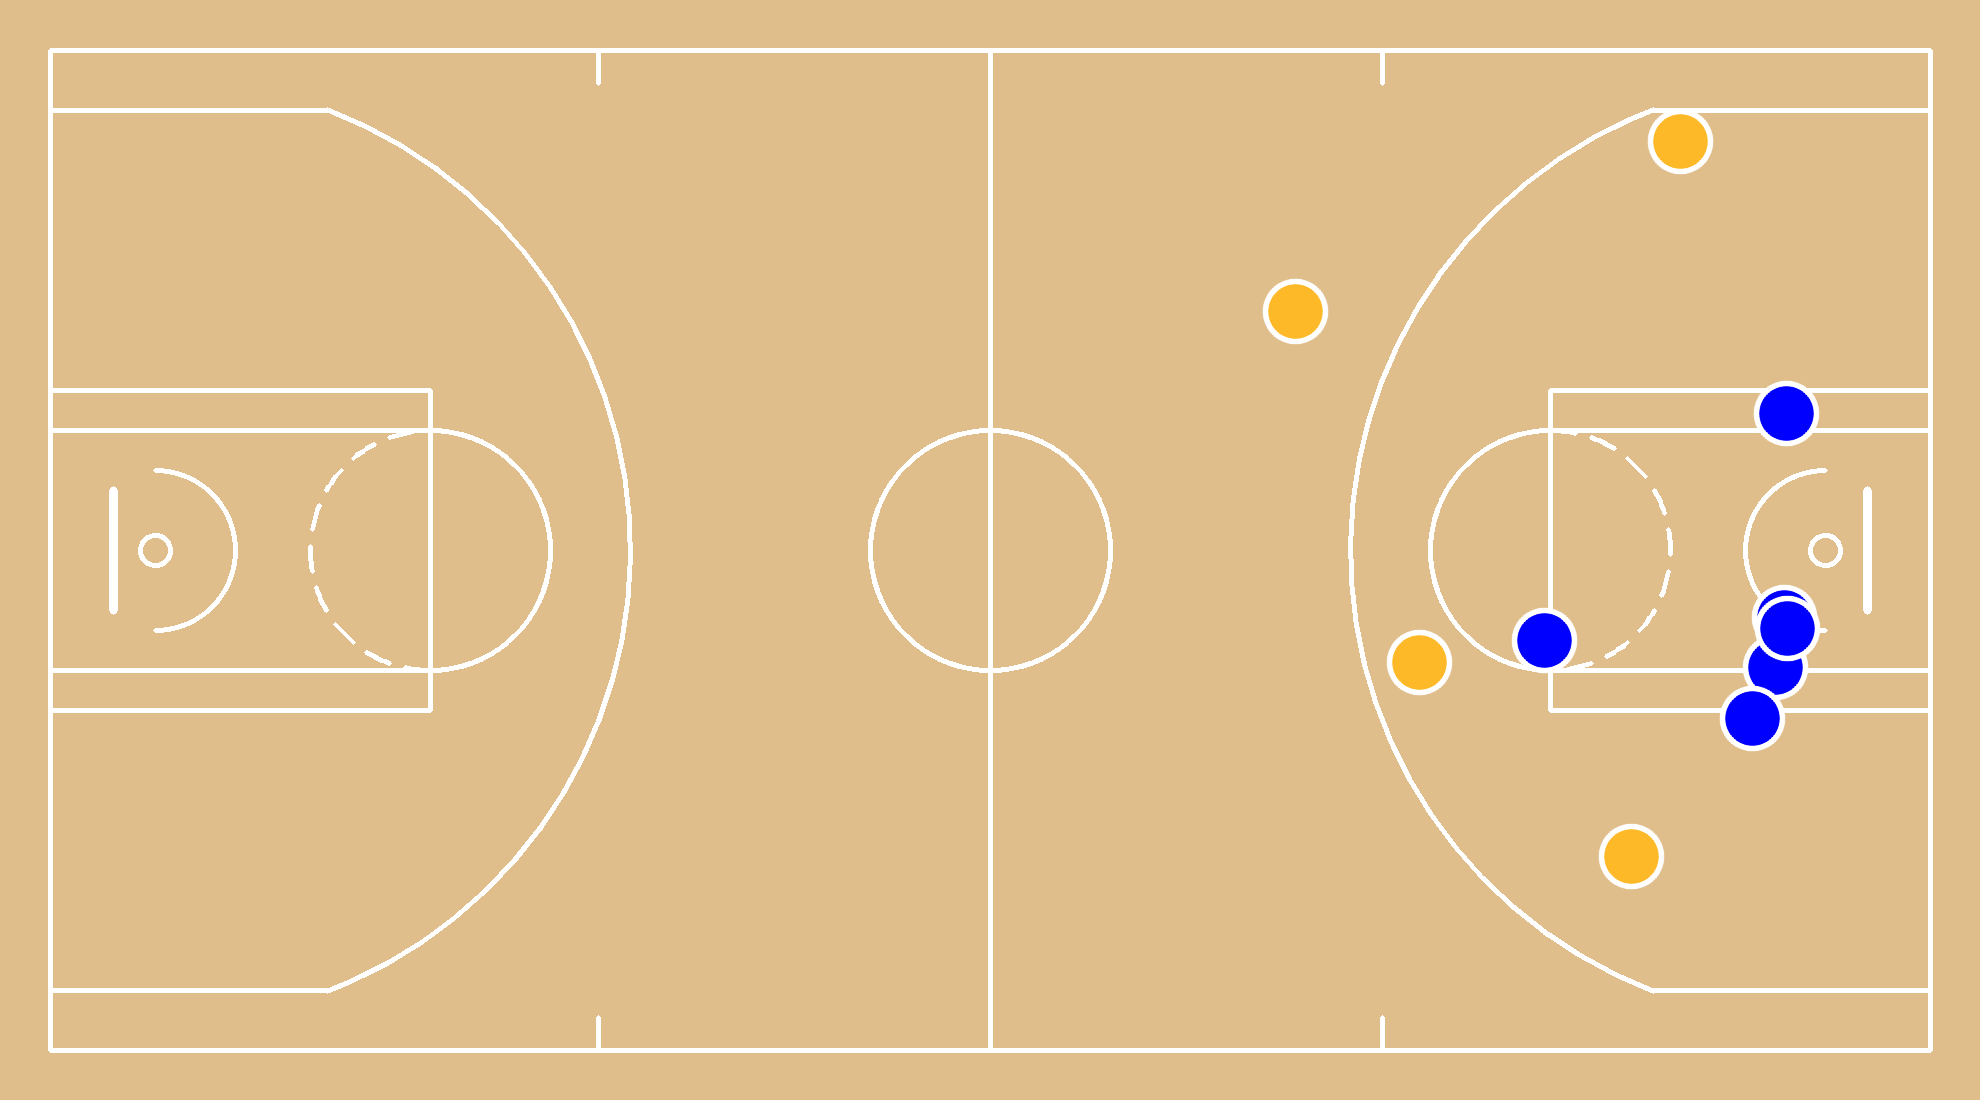
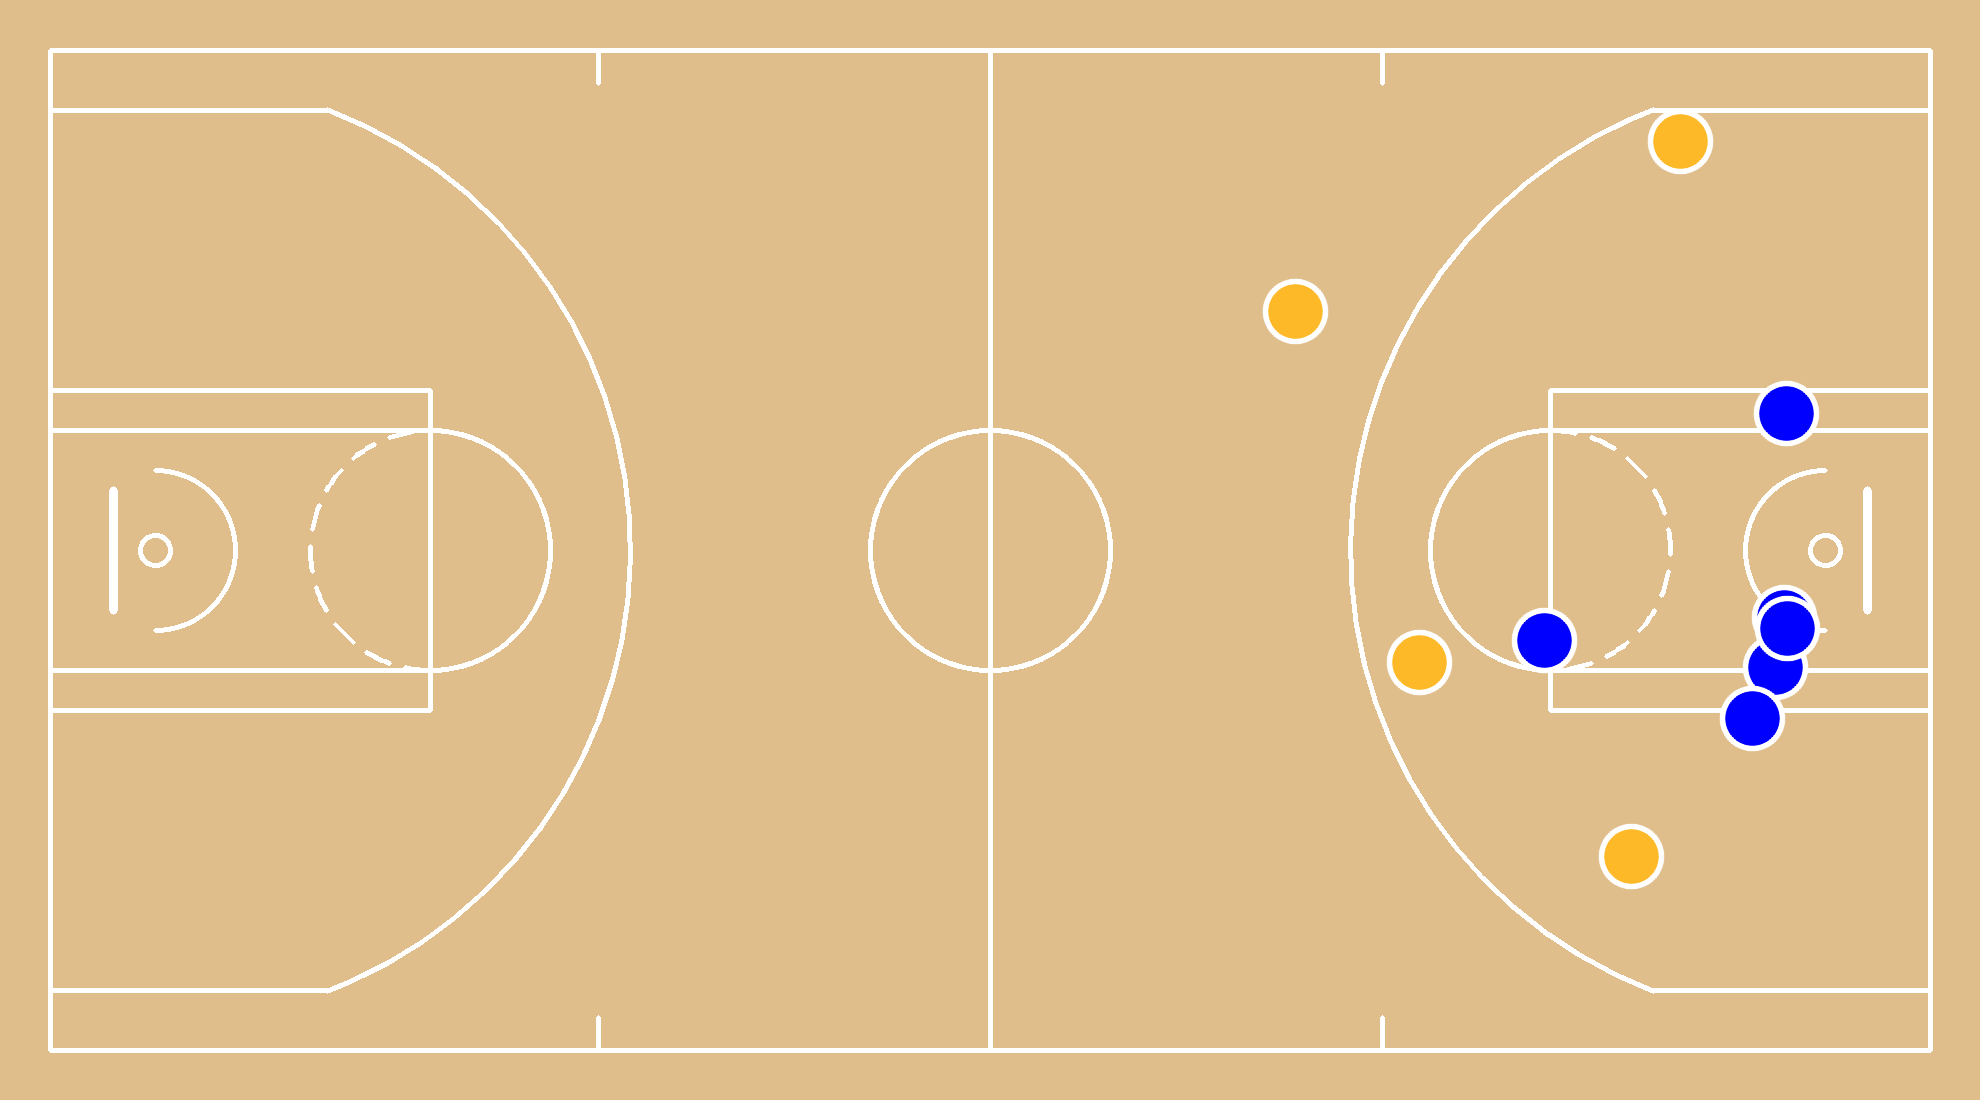
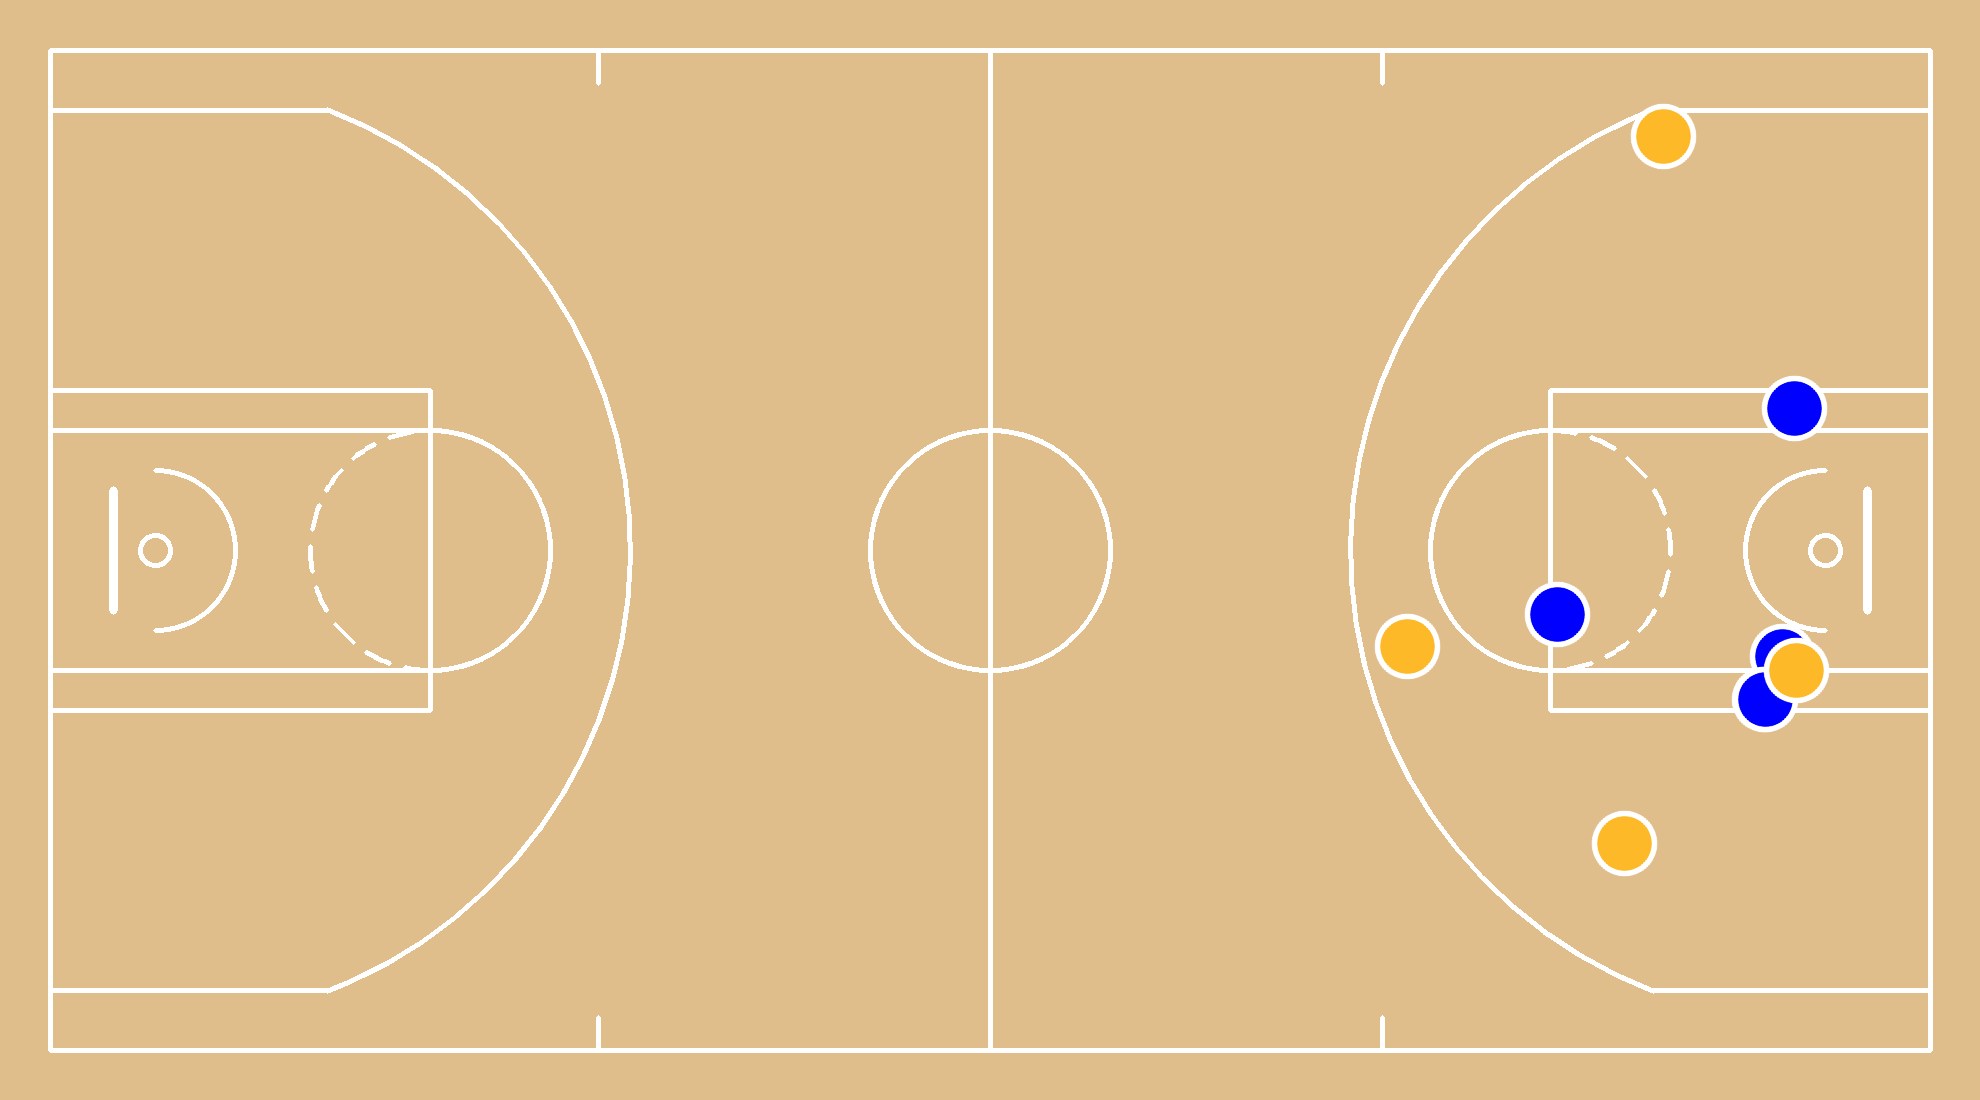
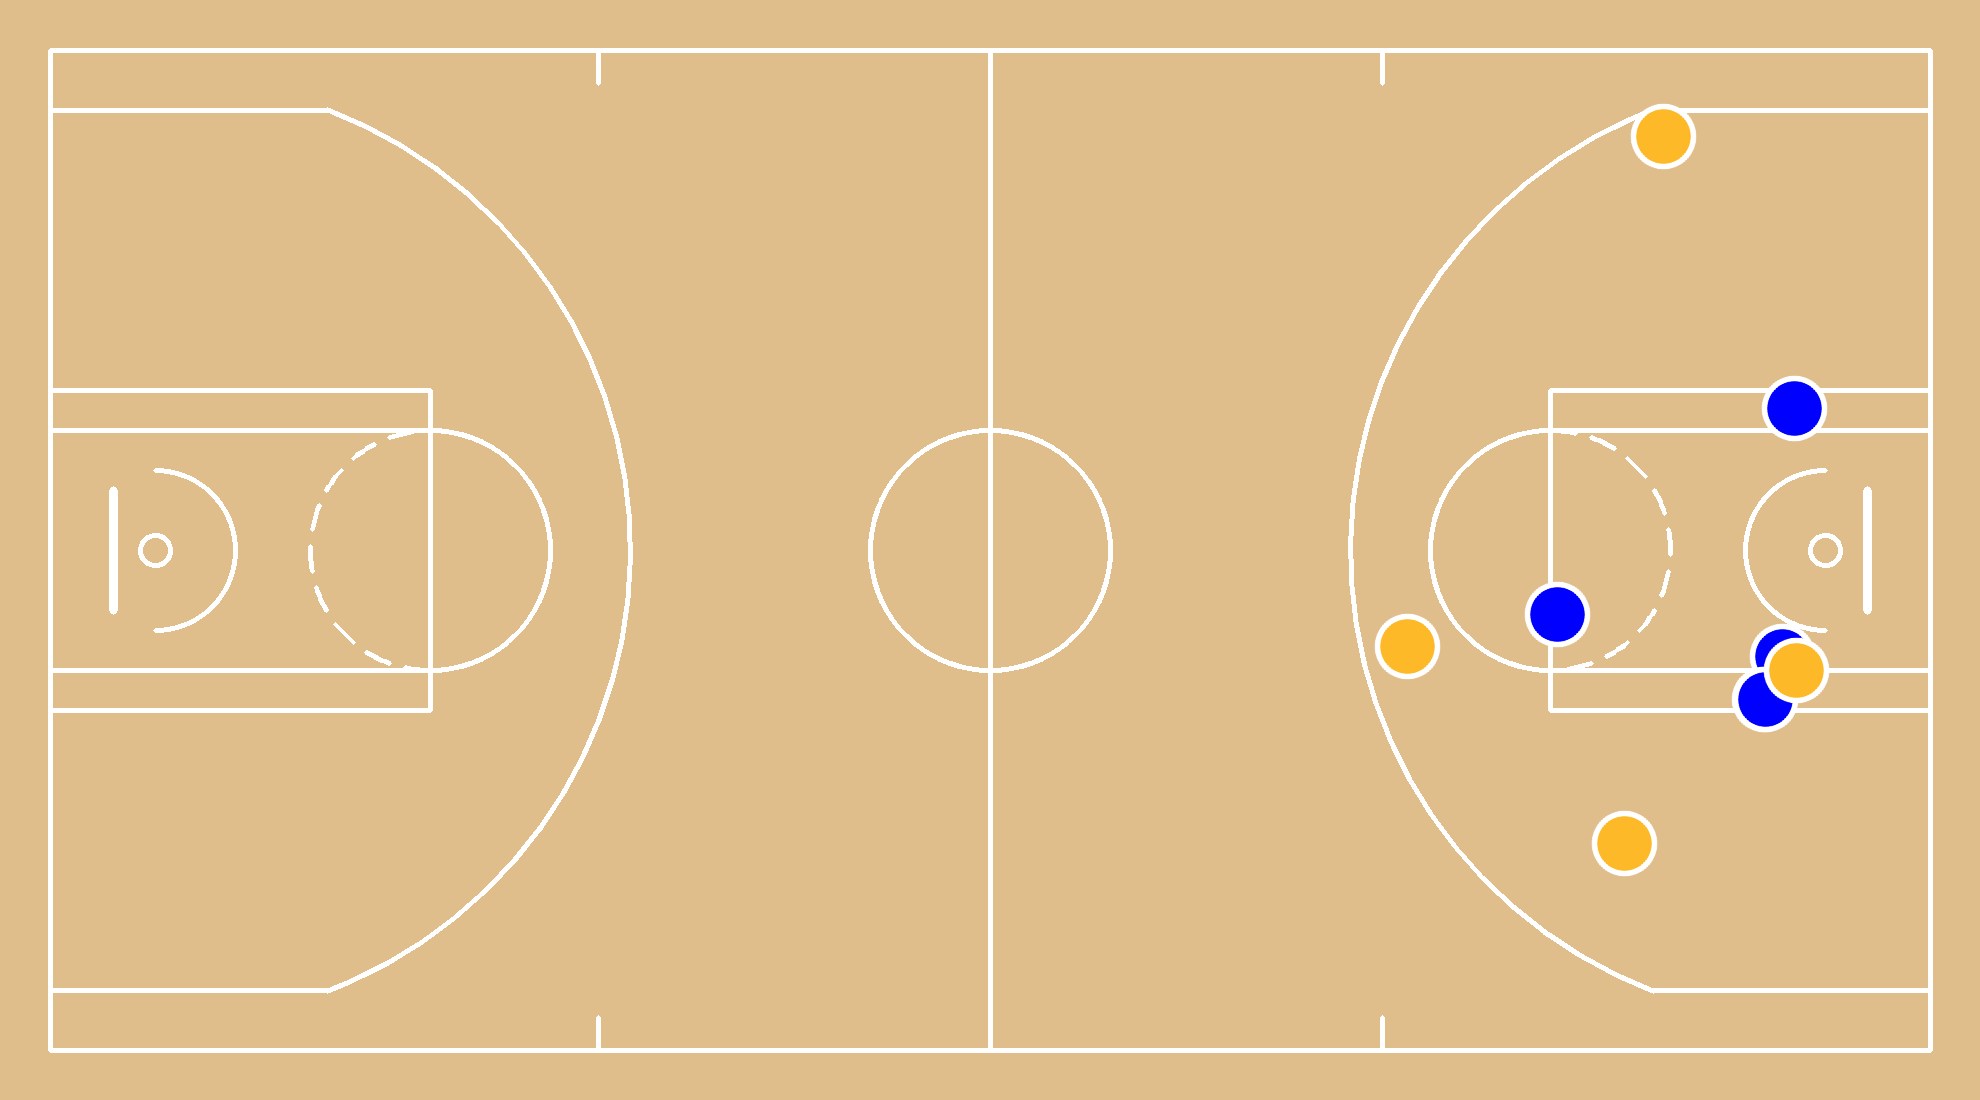
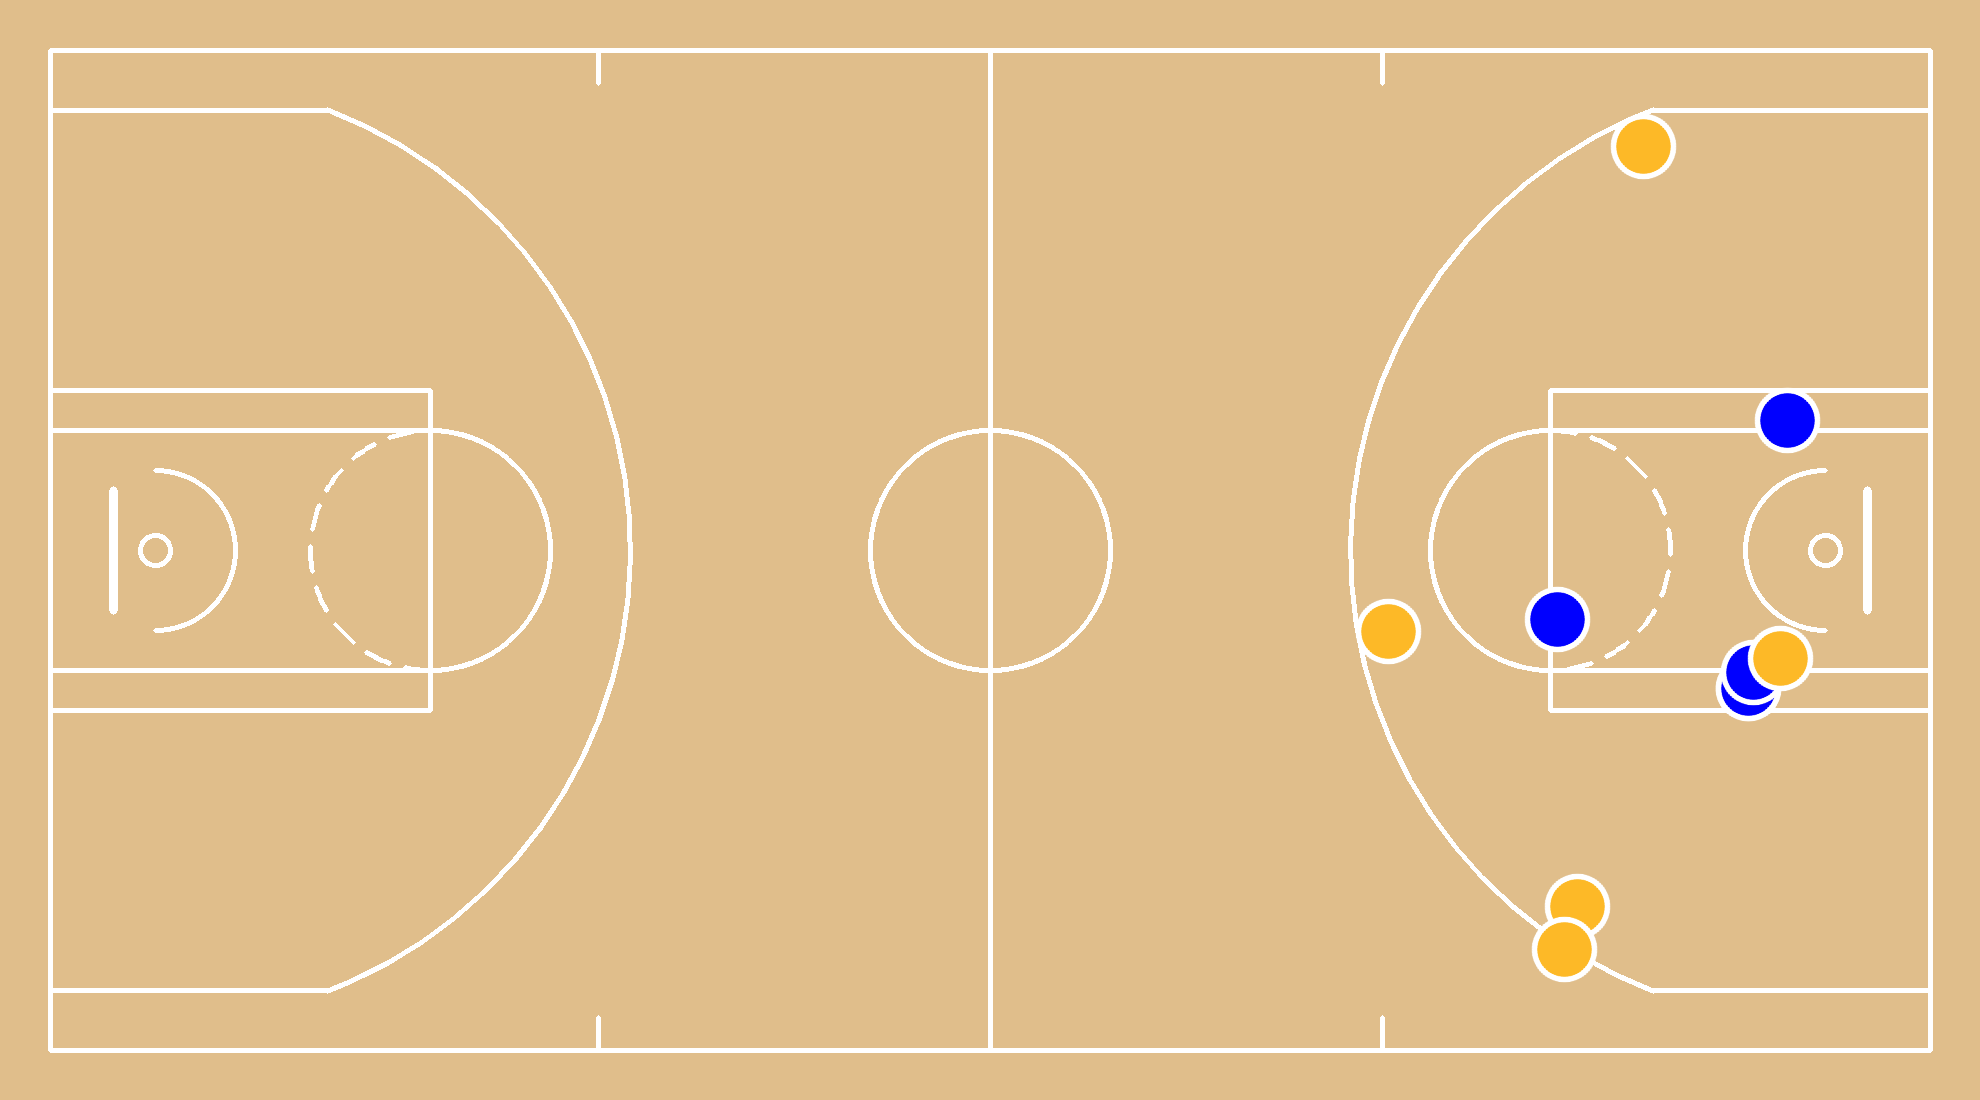
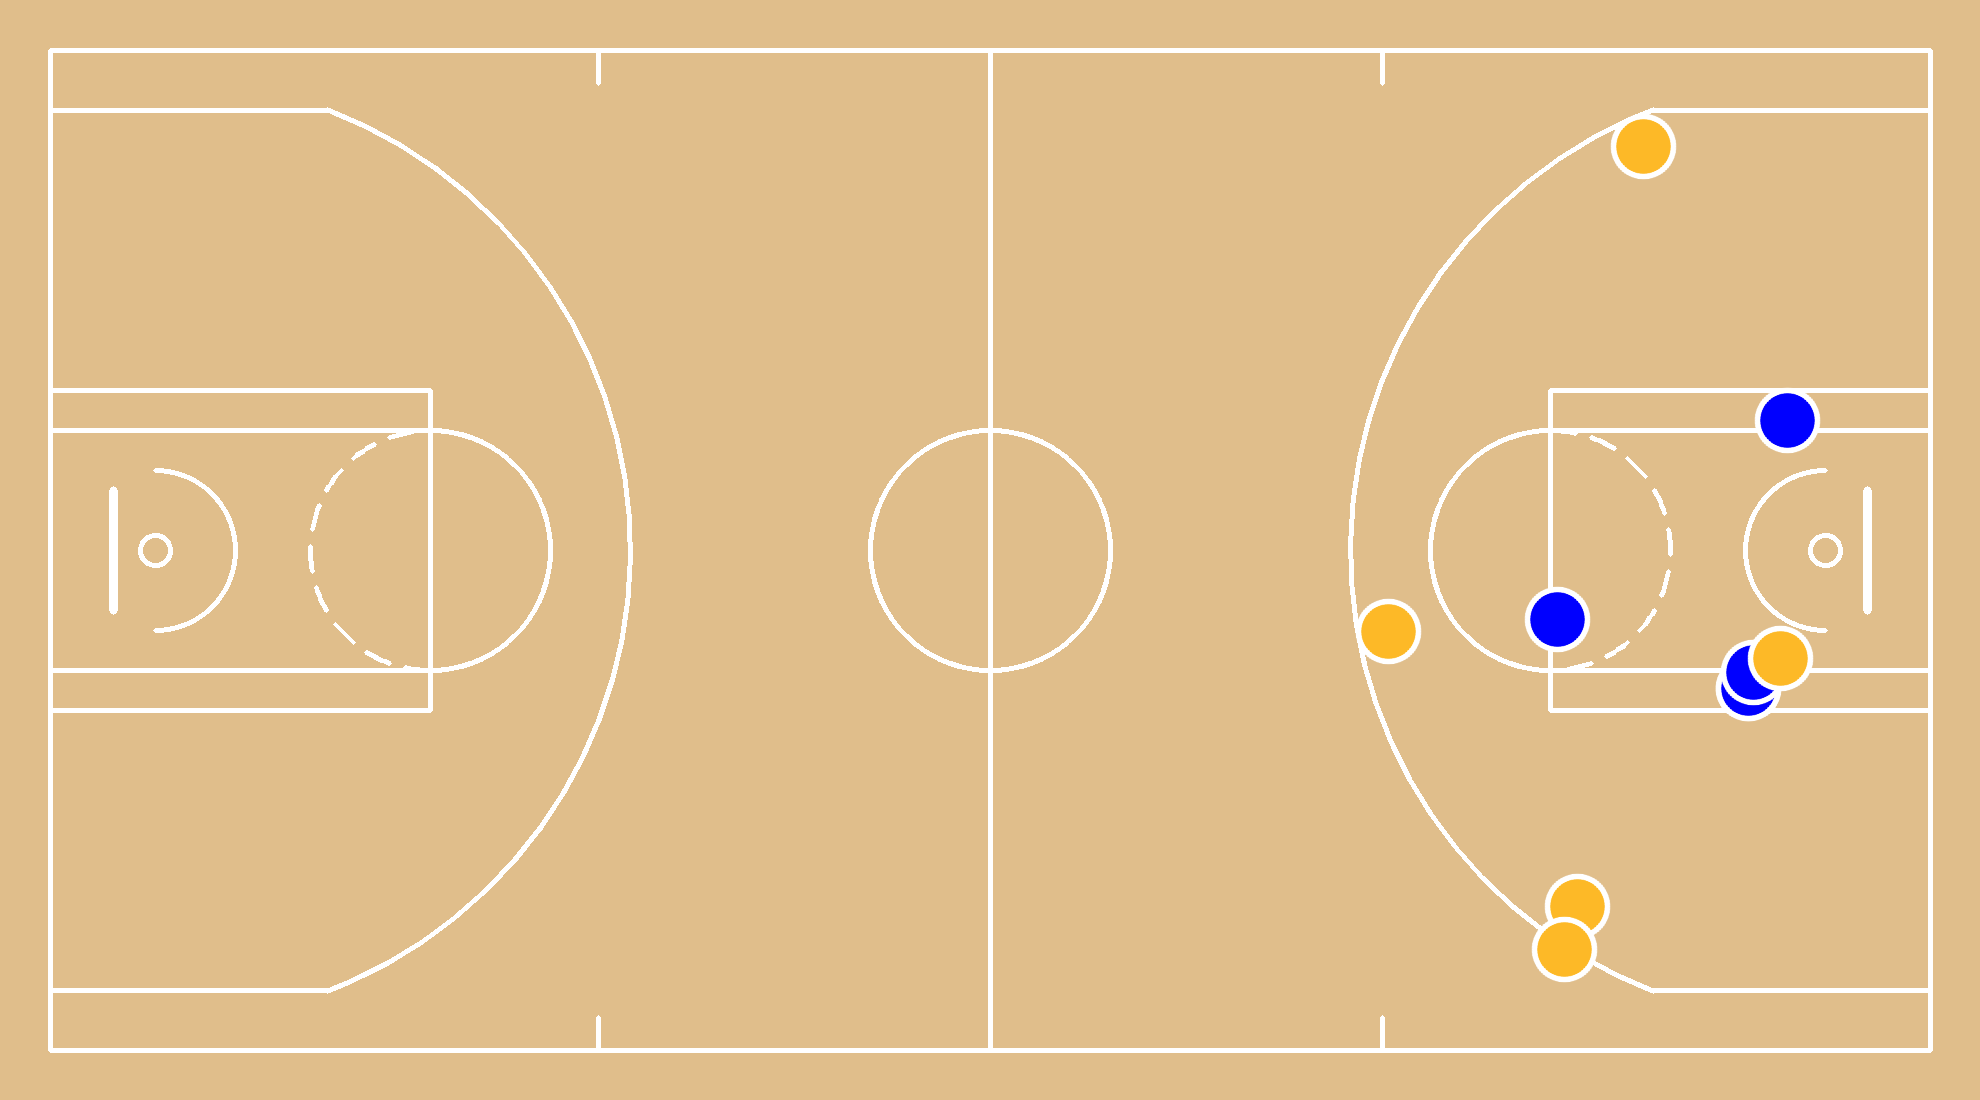
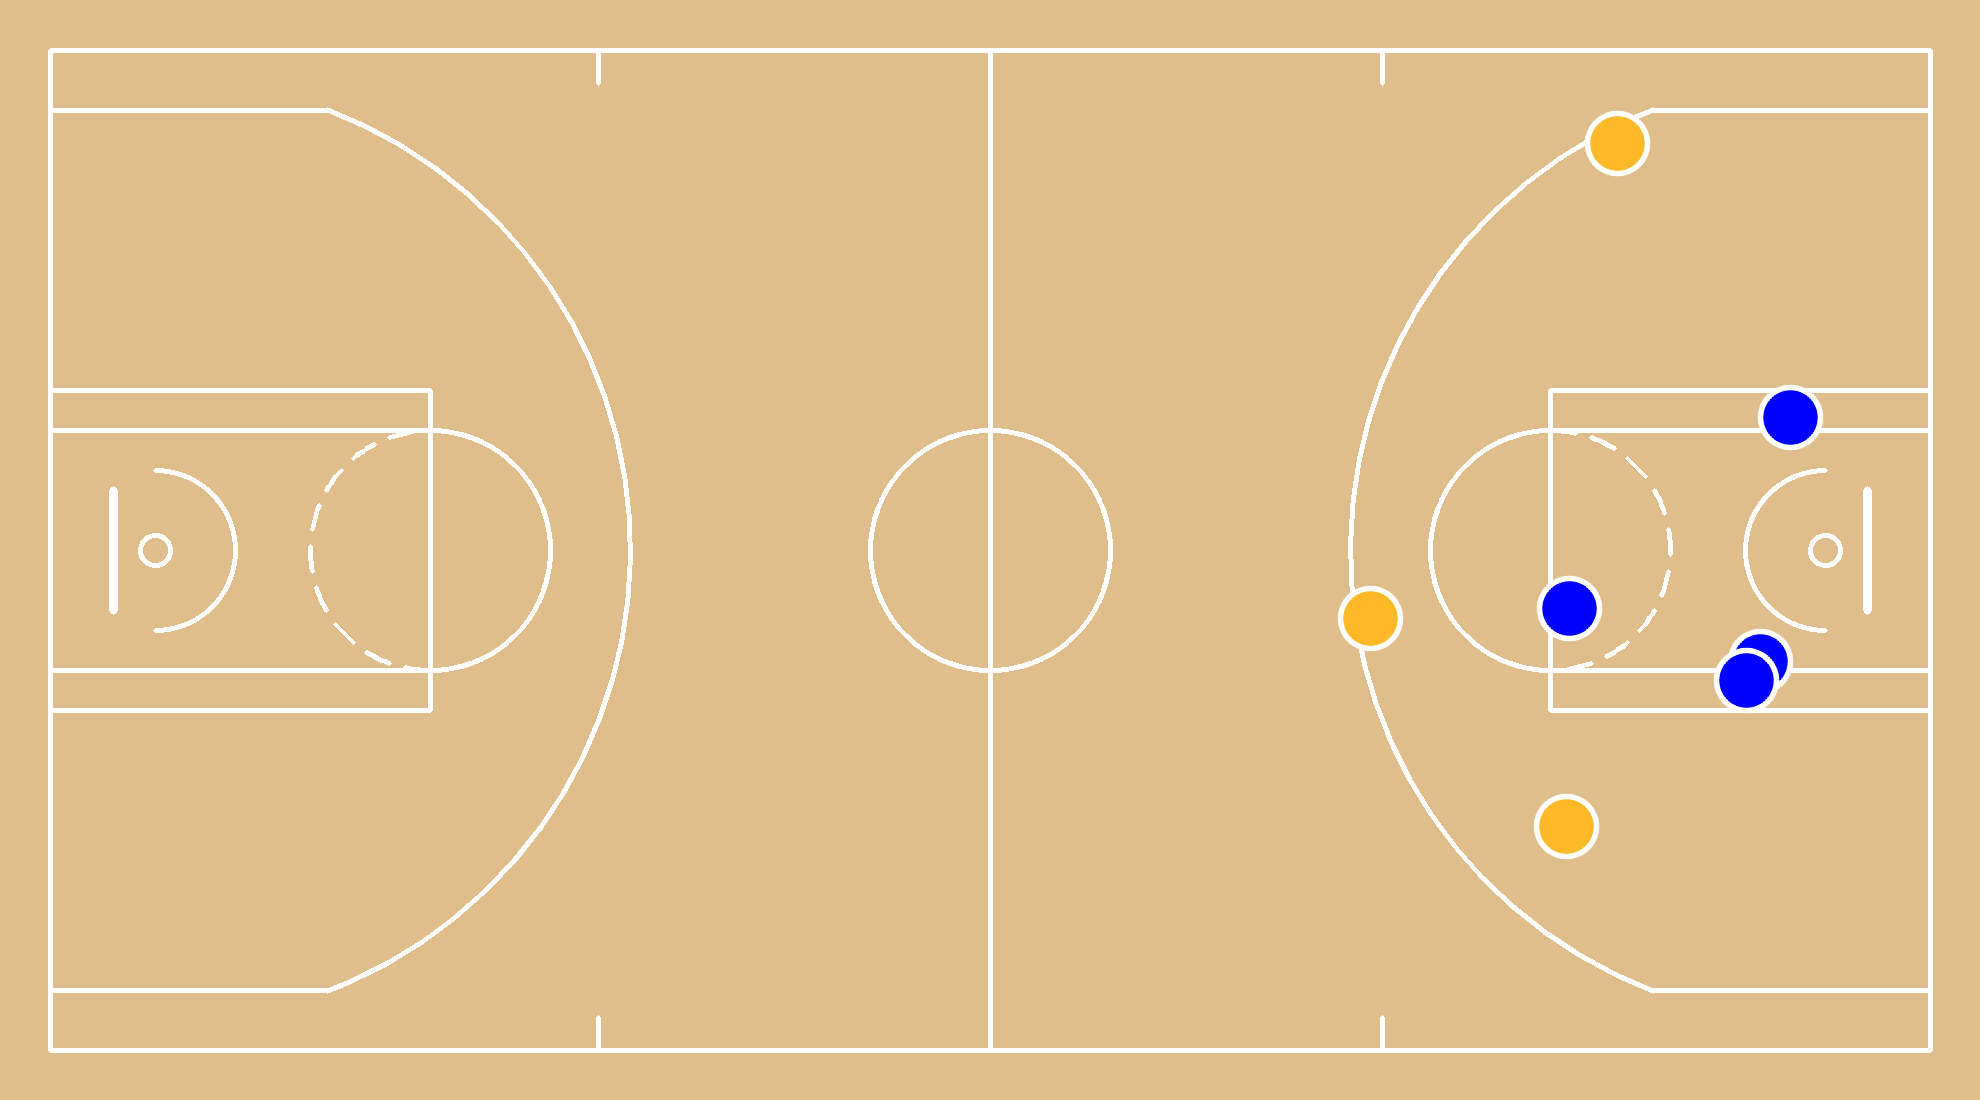

In [37]:
# Final Output Table
from IPython.display import display, HTML
import base64
from io import BytesIO
from PIL import Image

def numpy_to_base64(img_array):
    """Convert numpy array to base64 for HTML display."""
    if img_array is None:
        return ""
    img = Image.fromarray(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
    buffer = BytesIO()
    img.save(buffer, format="PNG")
    return base64.b64encode(buffer.getvalue()).decode()

# Regenerate events with full court views
print("Regenerating events with complete bird's eye views...")
config = CourtConfiguration(league=League.NBA, measurement_unit=MeasurementUnit.FEET)
final_results = []
for event in all_events:
    if event['action'].strip().lower() == "in possession":
        continue

    full_court = generate_full_court_view(event['frame'], config)
    final_results.append({
        'Timestamp': event['timestamp_formatted'],
        'Player': event['player'],
        'Action': event['action'],
        'court_view': full_court,
        'frame': event['frame']
    })

# Create HTML table with images
html = """
<h2>Task 2.2 Results: Player Actions Analysis</h2>
<table border="1" style="border-collapse: collapse;">
<tr>
    <th style="padding: 10px;">Timestamp</th>
    <th style="padding: 10px;">Player</th>
    <th style="padding: 10px;">Action</th>
    <th style="padding: 10px;">Bird's Eye View</th>
</tr>
"""

for result in final_results:
    court_b64 = numpy_to_base64(result['court_view'])
    html += f"""
    <tr>
        <td style="padding: 10px; text-align: center;">{result['Timestamp']}</td>
        <td style="padding: 10px;">{result['Player']}</td>
        <td style="padding: 10px;">{result['Action']}</td>
        <td style="padding: 10px;"><img src="data:image/png;base64,{court_b64}" width="300"/></td>
    </tr>
    """

html += "</table>"

display(HTML(html))
